# Downloading, pre-processing and running cNMF on Zepp et. al 2021 data
1. Obtaining the AnnData object and complementary metadata
2. Filtering cells
3. Subsetting and splitting the dataset by developmental stage, and selecting joint highly variable genes (HVG)
4. Running consensus NMF (cNMF) per stage
5. Selecting parameters for the cNMF


In [1]:
%%time
%load_ext autoreload
%autoreload 2

#debug:
# from importlib import reload

import sys
import os
import time
import warnings

    
import numpy as np
import pandas as pd
from scipy import sparse
# from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from gepdynamics import _utils, _constants, cnmf, pfnmf, comparator, plotting

warnings.filterwarnings("ignore", category=FutureWarning)

sc.settings.n_jobs=-1

_utils.cd_proj_home()
print(os.getcwd())

/cs/labs/mornitzan/yotamcon/gep-dynamics
CPU times: user 2.8 s, sys: 1.36 s, total: 4.17 s
Wall time: 10.6 s


In [2]:
results_dir = _utils.set_dir('results')
results_dir = _utils.set_dir(results_dir.joinpath('zepp'))
data_dir = _utils.set_dir('data')
GSE_dir = _utils.set_dir(data_dir.joinpath('GSE149563'))

## 1. Obtaining the AnnData object and complementary metadata
The adata contains log1p(CP10K) data, we un-transform the data to have the original counts as `X`

In [3]:
%%script --no-raise-error false # remove this to run the downloading

# Adata downloaded from https://data-browser.lungmap.net/explore/projects/00f056f2-73ff-43ac-97ff-69ca10e38c89/get-curl-command
# by running this for the adata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22h5ad%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fe42d976a-5137-5422-be32-39008e1d53d7.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config - )
# and then running this for the metadata: 
!(cd {GSE_dir.as_posix()} && curl --location --fail 'https://service.azul.data.humancellatlas.org/manifest/files?catalog=lm3&format=curl&filters=%7B%22fileFormat%22%3A+%7B%22is%22%3A+%5B%22csv%22%5D%7D%2C+%22projectId%22%3A+%7B%22is%22%3A+%5B%2200f056f2-73ff-43ac-97ff-69ca10e38c89%22%5D%7D%2C+%22genusSpecies%22%3A+%7B%22is%22%3A+%5B%22Mus+musculus%22%5D%7D%7D&objectKey=manifests%2Fed538a08-689b-530d-a661-e1756132b883.1ad7b2a4-0d0f-55d3-9d0c-6c37e8d46dc8.curlrc' | curl --config -)

download_dir = GSE_dir.joinpath('a078a6cb-a72a-305c-80df-cf35aedd01ff')
! mv {download_dir.as_posix()}/* {GSE_dir.as_posix()}
! rmdir {download_dir.as_posix()}

In [4]:
%%time

%time adata = sc.read_h5ad(GSE_dir.joinpath('JZ_Mouse_TimeSeries.h5ad'))
metadata = pd.read_csv(GSE_dir.joinpath('AllTimePoints_metadata.csv'), index_col=0)

adata.obs['celltype'] = metadata.var_celltype
adata.obs['compartment'] = metadata.var_compartment

untransformed = sparse.csr_matrix(adata.obs.n_molecules.values[:, None].astype(np.float32) / 10_000).multiply(adata.X.expm1())
adata.X = sparse.csr_matrix(untransformed).rint()

del untransformed, metadata

adata

CPU times: user 8.73 s, sys: 863 ms, total: 9.6 s
Wall time: 12 s
CPU times: user 21.4 s, sys: 2.01 s, total: 23.4 s
Wall time: 25.8 s


AnnData object with n_obs × n_vars = 67794 × 18129
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment'
    var: 'name'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [5]:
adata.obs.development_stage = adata.obs.development_stage.cat.rename_categories(
    {'Adult': 'P42', 'E12.5': 'E12', 'E15.5': 'E15', 'E17.5': 'E17'}).cat.reorder_categories(
    ['E12', 'E15', 'E17', 'P3', 'P7', 'P15', 'P42'])

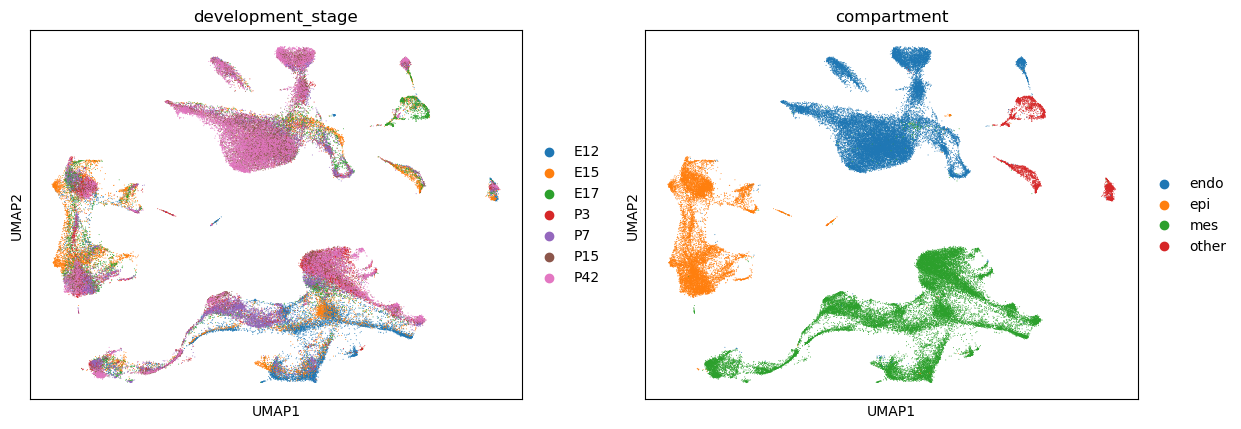

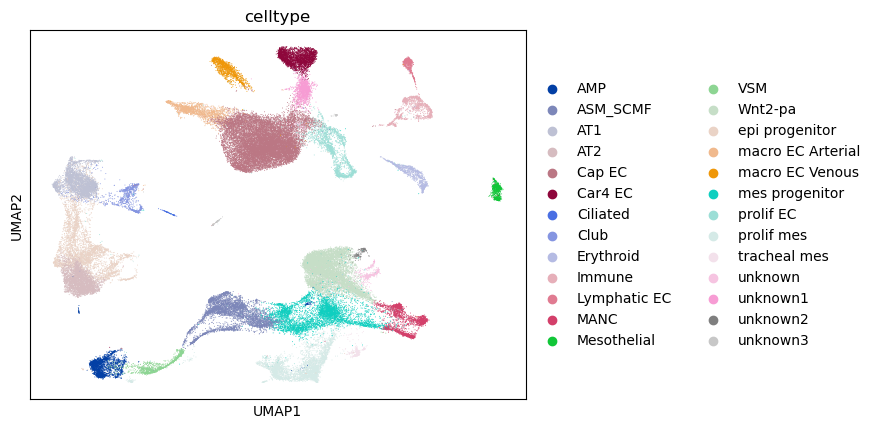

In [6]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.umap(adata, color=['development_stage', 'compartment'])
    sc.pl.umap(adata, color=['celltype'])

adata.uns['development_stage_colors_dict'] = dict(zip(adata.obs['development_stage'].cat.categories, adata.uns['development_stage_colors']))
adata.uns['compartment_colors_dict'] = dict(zip(adata.obs['compartment'].cat.categories, adata.uns['compartment_colors']))
adata.uns['celltype_colors_dict'] = dict(zip(adata.obs['celltype'].cat.categories, adata.uns['celltype_colors']))

In [7]:
pd.crosstab(adata.obs.development_stage, adata.obs.compartment)

compartment        endo   epi   mes  other
development_stage                         
E12                 133   679  7752    403
E15                1095  3676  2516   1017
E17                1681  2573  2012    937
P3                 2991  2196  5063    141
P7                 3992  1632  4433    140
P15                7345   739  2327    108
P42                7646  1041  3404    122

In [8]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage   E12   E15  E17    P3    P7   P15   P42
celltype                                                  
AMP                 178   224  317   327   356   189   376
ASM_SCMF            732   227  417   678  1936   378   263
AT1                 125   711  779   865   344   248   355
AT2                  54   243  739   815   811   432   517
Cap EC               55   557  783  1517  2073  5239  4875
Car4 EC               0     0   30   346   430   908  1078
Ciliated              0     0    5    61     5     2     4
Club                112   418  157    94    72    26    54
Erythroid            53   601  114    18    70    65     7
Immune              117   278  764     7     5    21    49
Lymphatic EC         14    62   66    92    72   108   169
MANC                740    86   82   315   244   202   419
Mesothelial         233   138   59   116    65    22    66
VSM                  74    66   95   233   279   244   205
Wnt2-pa              53    90  811  3183   959  1207  1701
epi progenitor      291  2300  890   350   388    27   105
macro EC Arterial     0    19   91   254   254   402   661
macro EC Venous       1    38   64   176   268   283   451
mes progenitor     3216  1097  161    83   312     5    34
prolif EC            60   416  556   302   665    36    30
prolif mes         2509   713  103    83   295     7     2
tracheal mes        248     6    3    42     1     3     1
unknown               2     7   23   119    43    83   276
unknown1              3     3   91   304   230   369   382
unknown2              0     0    0     0     8     9   127
unknown3             97     4    3    11    12     4     6

13 mitochondrial genes


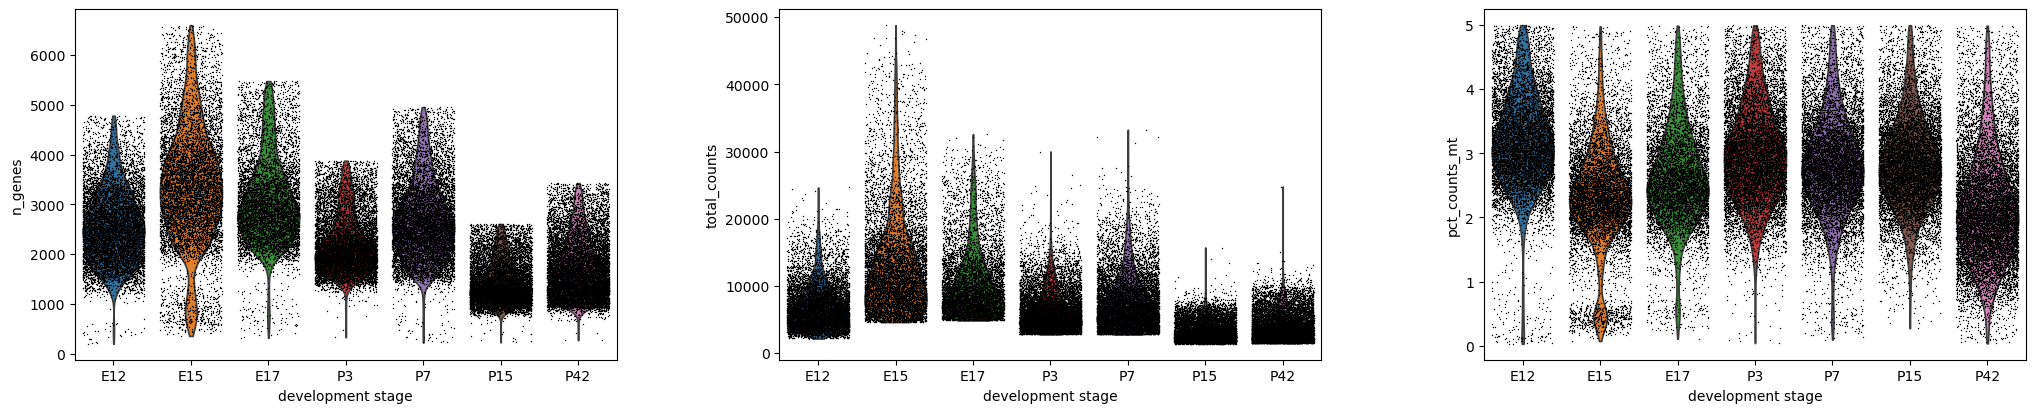

In [9]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
print(f"{np.sum(adata.var['mt'])} mitochondrial genes")
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_counts_mt',],
                 jitter=0.4, multi_panel=True, groupby='development_stage')

## 2 Filtering cells and genes

### 2.0 Basic removal of cells with <800 gens and genes in <20 cells and showing key statistics

In [11]:
adata = adata[adata.obs.development_stage.isin(['E12', 'E15', 'E17', 'P3', 'P7'])]
adata = adata[~adata.obs.celltype.str.startswith('unknown')]
adata = adata[adata.obs.celltype!='Ciliated'].copy()

In [12]:
%%time
print(f'before filtering shape was {adata.X.shape}')

# filtering cells with low number of genes
sc.pp.filter_cells(adata, min_genes=800)

# filtering genes with very low abundance
sc.pp.filter_genes(adata, min_cells=20)

# getting general statistics for counts abundance
sc.pp.filter_genes(adata, min_counts=0)
sc.pp.filter_cells(adata, min_counts=0)

print(f'after filtering shape is {adata.X.shape}')

_utils.joint_hvg_across_stages(adata, obs_category_key='development_stage', n_top_genes=5000)
adata

before filtering shape was (44031, 18129)


/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



after filtering shape is (43689, 17197)
CPU times: user 18.2 s, sys: 6.05 s, total: 24.3 s
Wall time: 21.9 s


AnnData object with n_obs × n_vars = 43689 × 17197
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'development_stage_colors', 'compartment_colors', 'celltype_colors', 'development_stage_colors_dict', 'compartment_colors_dict', 'celltype_colors_dict'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

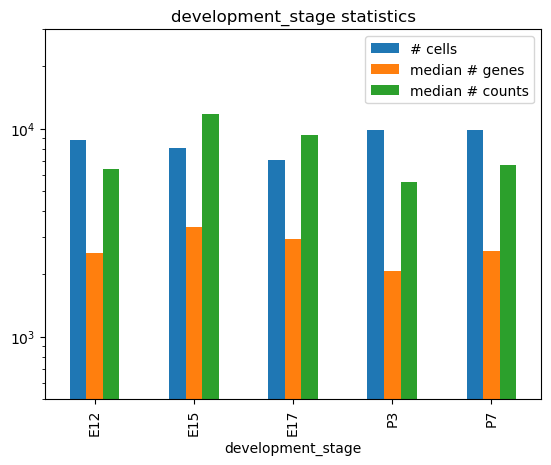

In [13]:
column_of_interest = 'development_stage'

stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
    [column_of_interest]).median()

stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                      stats_df], axis=1)
stats_df.columns = ['# cells', 'median # genes', 'median # counts']

stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((5e2, 3e4)))
plt.show()
del column_of_interest, stats_df

### 2.1 SVM to remove cells with umbiguous compartment assignment


In [14]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

In [15]:
%%time
k=10

adata.obs[f'predP{k}'] = None
for stage in adata.obs.development_stage.cat.categories:
    dat = adata[adata.obs.development_stage==stage].copy()
    sc.pp.normalize_total(dat, 5_000)
    sc.pp.log1p(dat)
    pca = PCA(n_components=k)
    pcs = pca.fit_transform(dat[:, dat.var.joint_highly_variable].X.toarray())
    svm_model = LinearSVC(C=0.00001, class_weight='balanced', dual=False)
    svm_model.fit(pcs, dat.obs.compartment)
    adata.obs.loc[adata.obs.development_stage==stage, f'predP{k}'] = svm_model.predict(pcs)

CPU times: user 25.5 s, sys: 6.85 s, total: 32.3 s
Wall time: 6.63 s


In [16]:
pd.crosstab(adata.obs.compartment, adata.obs.predP10)

predP10      endo    epi    mes  other
compartment                           
endo         8945    101     83    132
epi            47  10458     21     31
mes           580    520  19960    514
other          71     73    117   2036

In [17]:
adata.obs['compartment_cleaned'] = 'ambiguous'
adata.obs.loc[adata.obs.compartment==adata.obs.predP10, 'compartment_cleaned'] = adata[adata.obs.compartment==adata.obs.predP10].obs.compartment
adata.obs.compartment_cleaned.value_counts()

compartment_cleaned
mes          19960
epi          10458
endo          8945
ambiguous     2290
other         2036
Name: count, dtype: int64

In [18]:
%%time
k=10

adata.obs[f'predP{k}_twice'] = 'dropped'
for stage in adata.obs.development_stage.cat.categories:
    dat = adata[adata.obs.development_stage==stage].copy()
    sc.pp.normalize_total(dat, 5_000)
    sc.pp.log1p(dat)
    pca = PCA(n_components=k)
    pcs = pca.fit_transform(dat[:, dat.var.joint_highly_variable].X.toarray())
    svm_model = LinearSVC(C=0.00001, class_weight='balanced', dual=False)
    # unabiguous = dat.obs.compartment_cleaned!='ambiguous'
    # svm_model.fit(pcs[unabiguous], dat[unabiguous].obs.compartment_cleaned)
    
    svm_model.fit(pcs, dat.obs.compartment_cleaned)
    adata.obs.loc[dat.obs.index, f'predP{k}_twice'] = svm_model.predict(pcs)

CPU times: user 25.5 s, sys: 6.67 s, total: 32.2 s
Wall time: 6.6 s


In [19]:
pd.crosstab(adata.obs.compartment_cleaned, adata.obs.predP10_twice)

predP10_twice        ambiguous  endo    epi    mes  other
compartment_cleaned                                      
ambiguous                  217   596    645    241    591
endo                         0  8939      0      3      3
epi                          2     1  10451      2      2
mes                        591   100     22  18949    298
other                        1    53      5     63   1914

In [20]:
adata.obs.loc[adata.obs.compartment_cleaned!=adata.obs.predP10_twice, 'compartment_cleaned'] = 'ambiguous'

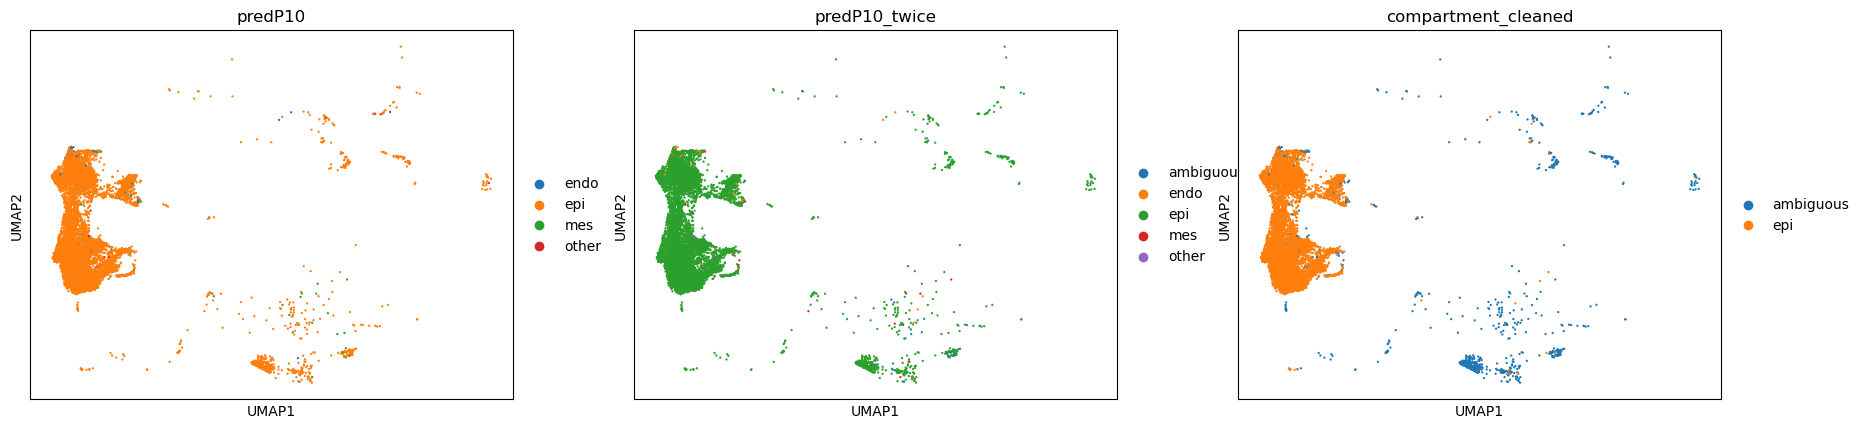

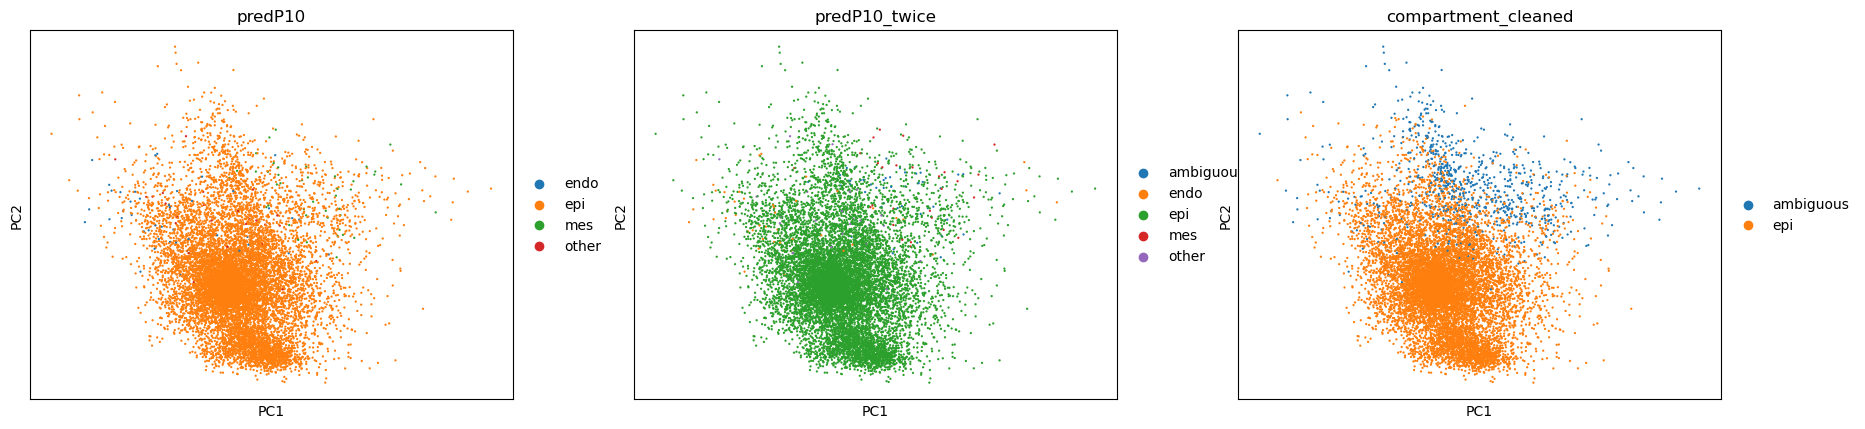

In [21]:
pred = 'predP10_twice'
pred = 'predP10'

bdata = adata[(adata.obs['predP10']=='epi') | (adata.obs['predP10_twice']=='epi') | (adata.obs.compartment=='epi')]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    sc.pl.umap(bdata, color=['predP10', 'predP10_twice', 'compartment_cleaned'])
    sc.pl.pca(bdata, color=['predP10', 'predP10_twice', 'compartment_cleaned'])

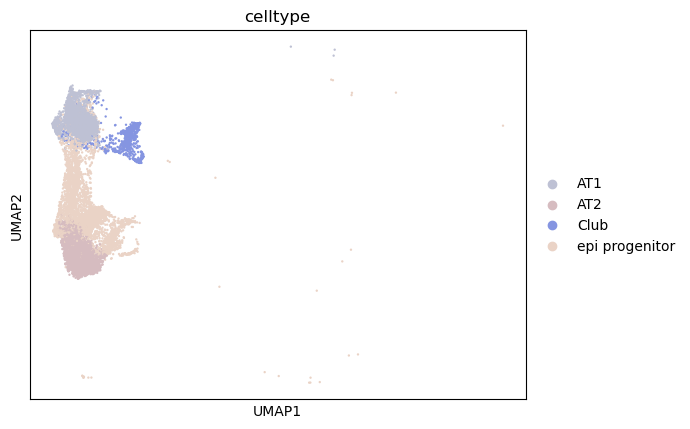

In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    sc.pl.umap(adata[adata.obs.compartment_cleaned=='epi'], color=['celltype'])

In [25]:
pd.crosstab(adata.obs.compartment_cleaned, adata.obs.compartment)

compartment          endo    epi    mes  other
compartment_cleaned                           
ambiguous             322    106   2625    383
endo                 8939      0      0      0
epi                     0  10451      0      0
mes                     0      0  18949      0
other                   0      0      0   1914

In [26]:
pd.crosstab(adata.obs.compartment_cleaned, adata.obs.development_stage)

development_stage     E12   E15   E17    P3    P7
compartment_cleaned                              
ambiguous            2101   591   295   197   252
endo                  114   984  1475  2661  3705
epi                   575  3635  2521  2110  1610
mes                  5787  2198  1932  4810  4222
other                 253   679   805   114    63

### 2.2 Cleaning the data - doublet removal

#### Training VAE towards Solo doublet removal

In [27]:
import torch
torch.set_float32_matmul_precision("high")

In [28]:
%%time
import scvi
from lightning.fabric.utilities.warnings import PossibleUserWarning
warnings.filterwarnings("ignore", category=PossibleUserWarning)

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning:

Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning:

Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.



CPU times: user 3.44 s, sys: 641 ms, total: 4.08 s
Wall time: 1min 2s


In [39]:
%%time
subdata = adata[adata.obs.compartment_cleaned!='ambiguous', adata.var.joint_highly_variable].copy()

scvi.model.SCVI.setup_anndata(subdata, labels_key='development_stage')
vae = scvi.model.SCVI(subdata, n_layers=3, n_hidden=256, n_latent=64, dispersion='gene-label')

vae

CPU times: user 1.01 s, sys: 336 ms, total: 1.35 s
Wall time: 1.35 s


SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [40]:
%time vae.train(accelerator='gpu', train_size=0.8, validation_size=0.1, check_val_every_n_epoch=1, batch_size=256, max_epochs=150)
vae

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 150/150: 100%|██████████| 150/150 [06:07<00:00,  2.45s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.84e+3]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [06:07<00:00,  2.45s/it, v_num=1, train_loss_step=1.79e+3, train_loss_epoch=1.84e+3]
CPU times: user 6min 4s, sys: 1.29 s, total: 6min 5s
Wall time: 6min 7s


SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [31]:
list(vae.history.keys())

['kl_weight',
 'train_loss_step',
 'validation_loss',
 'elbo_validation',
 'reconstruction_loss_validation',
 'kl_local_validation',
 'kl_global_validation',
 'train_loss_epoch',
 'elbo_train',
 'reconstruction_loss_train',
 'kl_local_train',
 'kl_global_train']

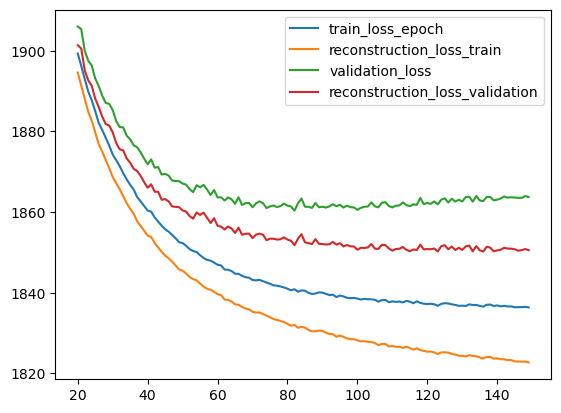

In [46]:
for stat in ['train_loss_epoch', 'reconstruction_loss_train', 'validation_loss', 'reconstruction_loss_validation']:
    plt.plot(vae.history[stat][20:], label=stat)
plt.legend()
plt.show()



In [42]:
# model_dir = results_dir.joinpath("scvi_model_batches")
model_dir = results_dir.joinpath("scvi_model_labels")

if vae.is_trained:
    vae.save(model_dir, overwrite=True)

# vae = scvi.model.SCVI.load(model_dir, adata=adata[:, adata.var.joint_highly_variable].copy())
vae

SCVI Model with the following params: 
n_hidden: 256, n_latent: 64, n_layers: 3, dropout_rate: 0.1, dispersion: gene-label, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

In [43]:
SCVI_LATENT_KEY = "X_scVI"

latent = vae.get_latent_representation(adata[:, adata.var.joint_highly_variable])
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(43689, 64)

Visualizing the SCVI latent space

In [44]:
%%time
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
vae_adata = sc.tl.umap(adata, min_dist=0.3, copy=True)

CPU times: user 1min 14s, sys: 15.5 s, total: 1min 30s
Wall time: 46.6 s


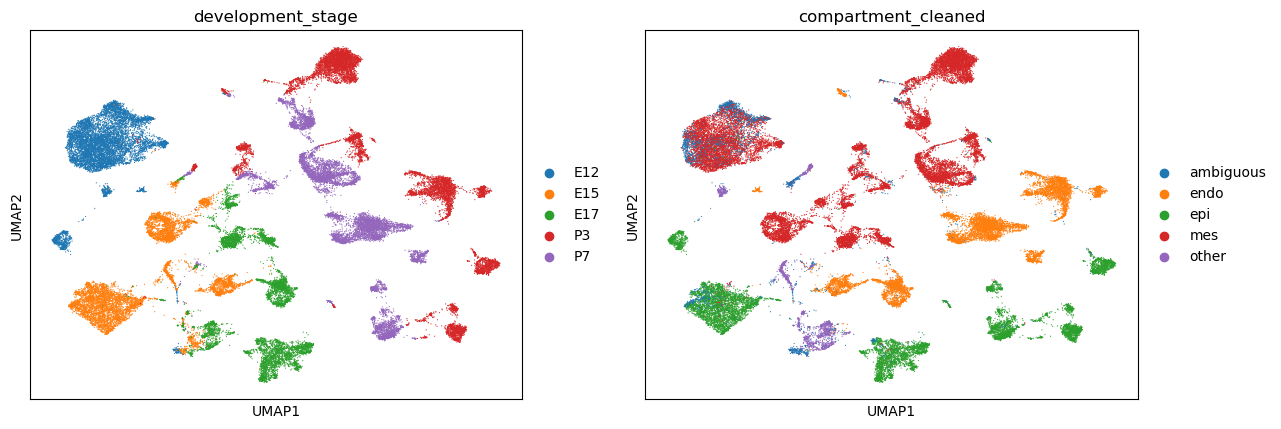

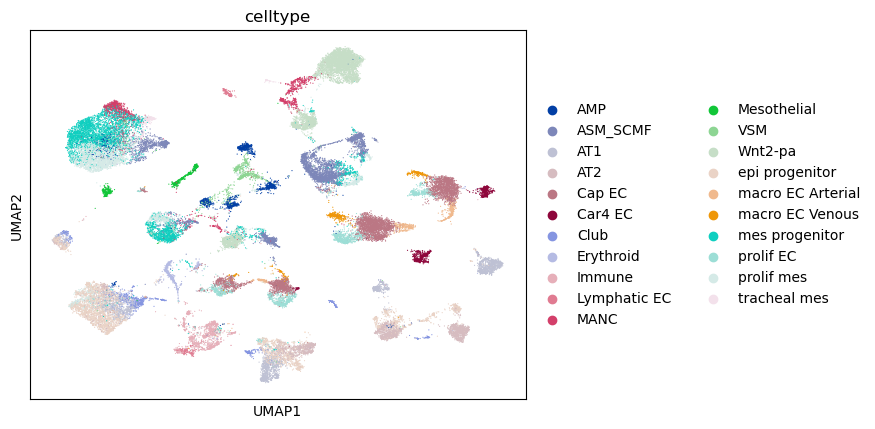

In [45]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    sc.pl.umap(vae_adata, color=['development_stage', 'compartment_cleaned'])
    sc.pl.umap(vae_adata, color=['celltype'])

#### Solo doublet prediction

In [49]:
SOLO_THRESHOLD = 0.5

stages = adata.obs.development_stage.cat.categories
stages

Index(['E12', 'E15', 'E17', 'P3', 'P7'], dtype='object')

In [48]:
adata.obs['doublet_softmax'] = np.nan

working on stage E12 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 69/600:  12%|█▏        | 69/600 [04:56<38:05,  4.30s/it, v_num=1, train_loss_step=0.00692, train_loss_epoch=0.0353]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.046. Signaling Trainer to stop.
prediction
singlet    5936
doublet     793
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              18       96
epi               90      485
mes              641     5146
other             44      209


/tmp/ipykernel_3100412/3641586752.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                  20      105
AT2                   6       47
Club                 15       95
epi progenitor       49      238


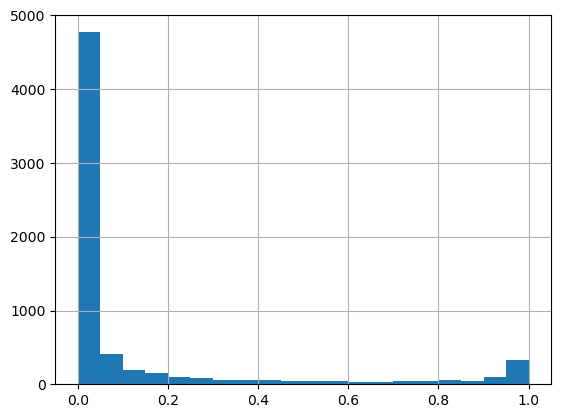

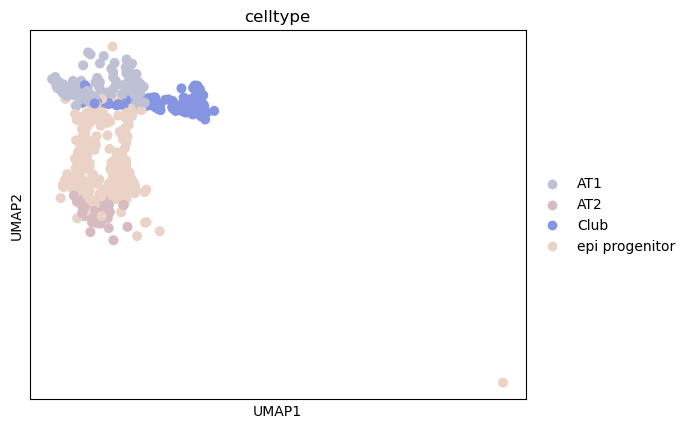

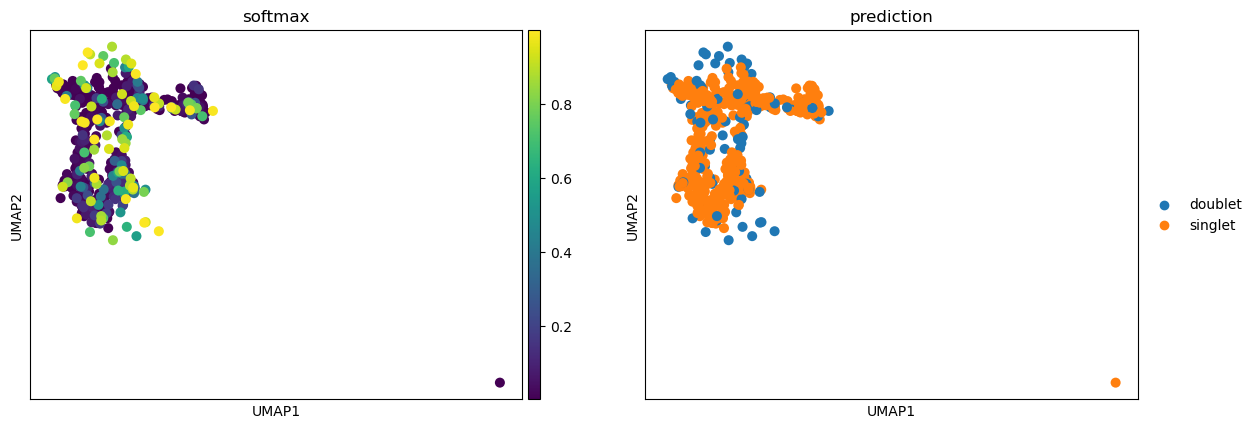

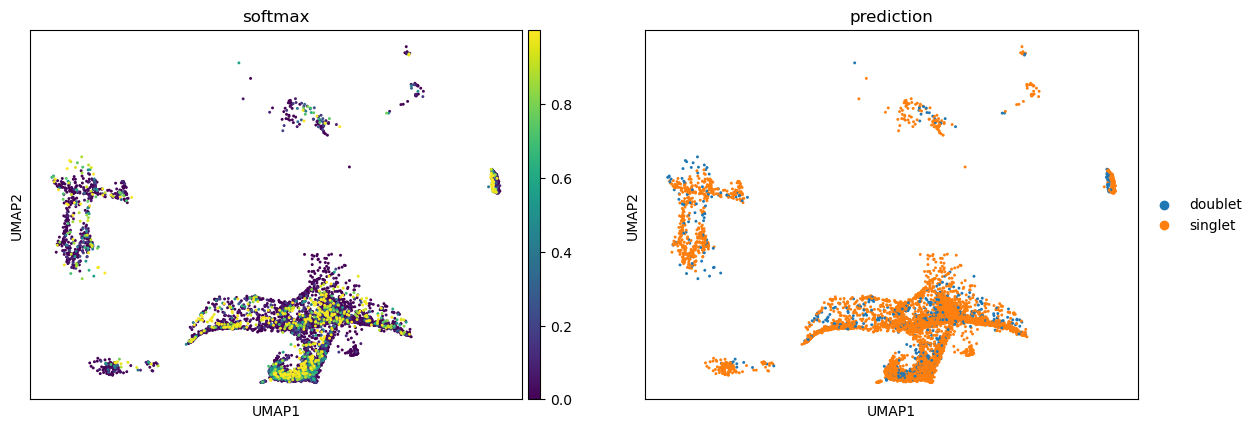

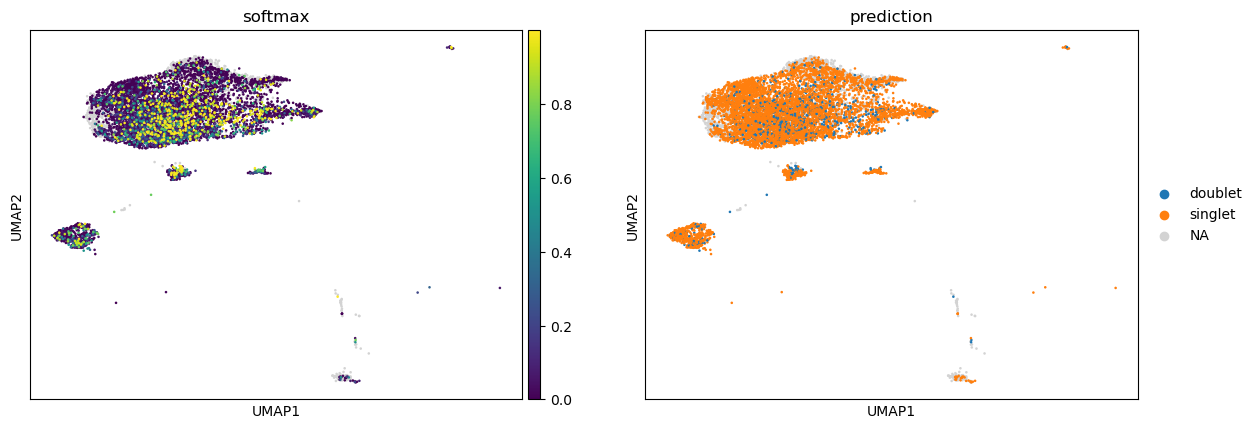

working on stage E15 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 97/600:  16%|█▌        | 97/600 [07:43<40:01,  4.78s/it, v_num=1, train_loss_step=0.00853, train_loss_epoch=0.0383]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.048. Signaling Trainer to stop.
prediction
singlet    6200
doublet    1296
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             191      793
epi              841     2794
mes              194     2004
other             70      609


/tmp/ipykernel_3100412/3641586752.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                 215      486
AT2                   8      234
Club                102      310
epi progenitor      516     1764


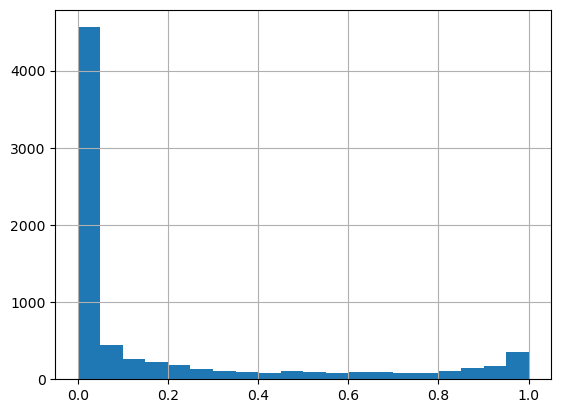

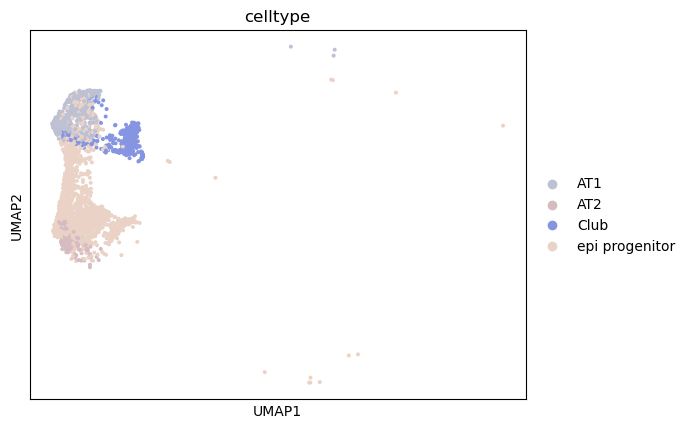

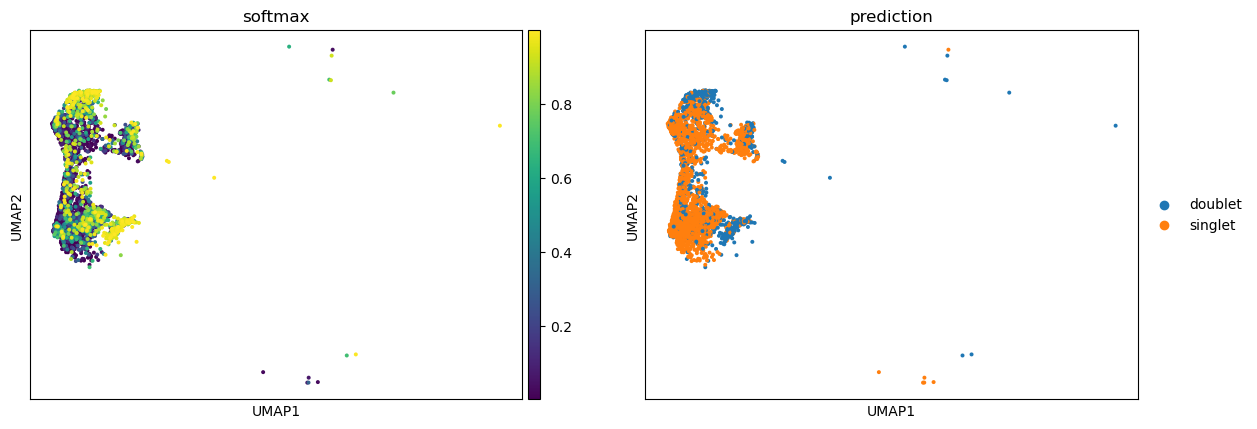

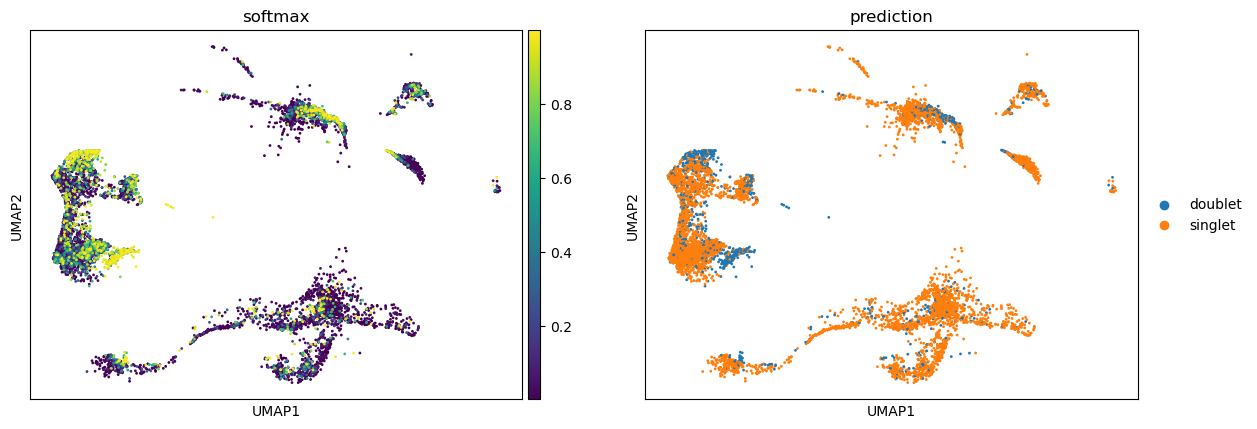

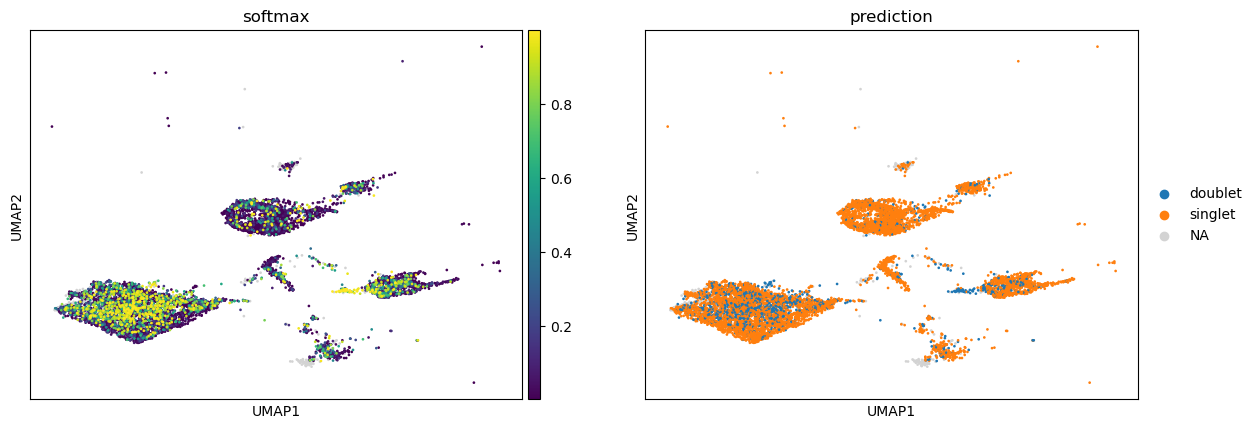

working on stage E17 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 103/600:  17%|█▋        | 103/600 [07:28<36:06,  4.36s/it, v_num=1, train_loss_step=0.0134, train_loss_epoch=0.0361] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.040. Signaling Trainer to stop.
prediction
singlet    5598
doublet    1135
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             248     1227
epi              621     1900
mes              168     1764
other             98      707


/tmp/ipykernel_3100412/3641586752.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                 153      609
AT2                  52      687
Club                 33      120
epi progenitor      383      484


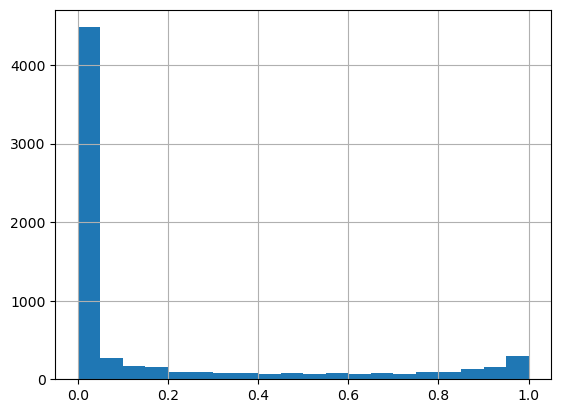

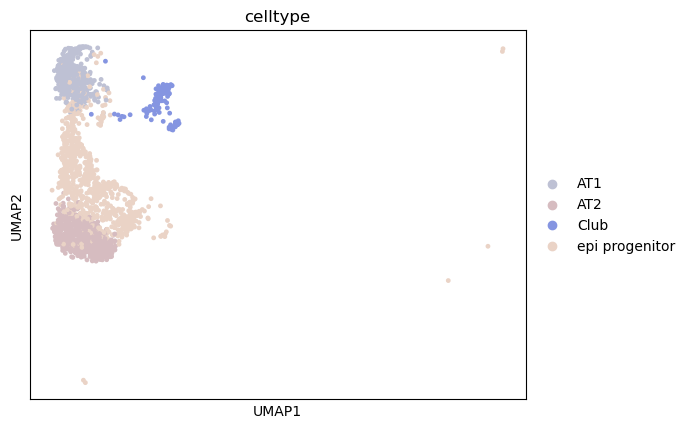

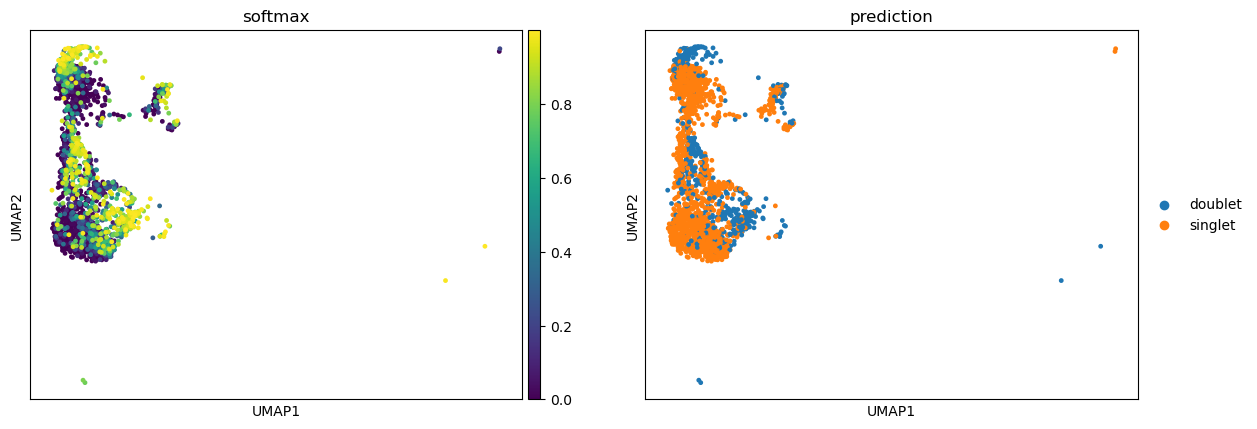

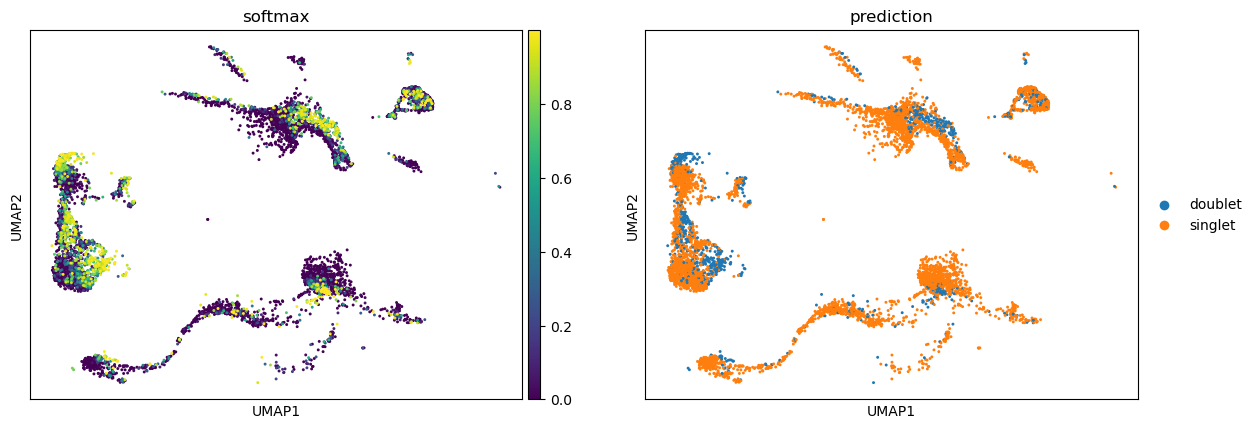

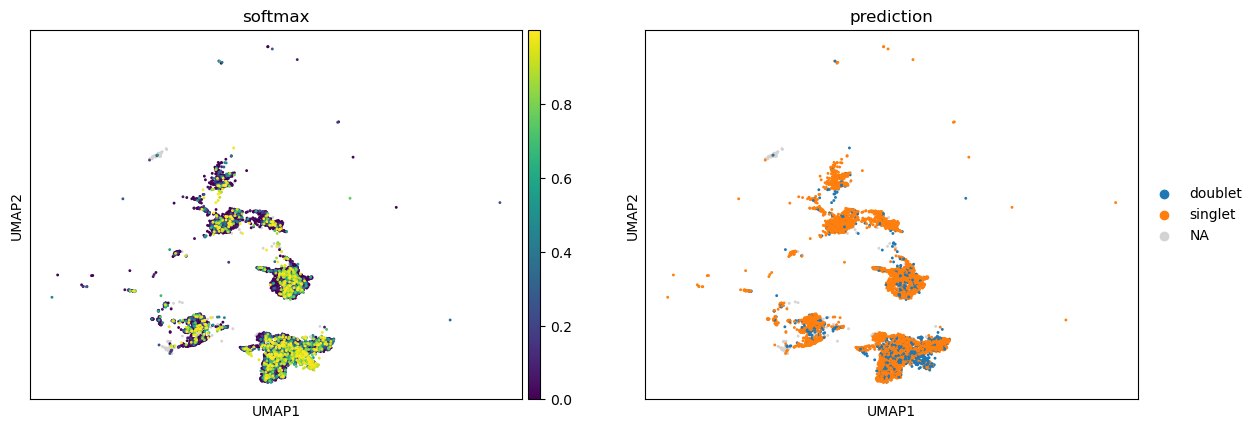

working on stage P3 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 56/600:   9%|▉         | 56/600 [05:44<55:45,  6.15s/it, v_num=1, train_loss_step=0.0531, train_loss_epoch=0.0343]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.036. Signaling Trainer to stop.
prediction
singlet    8104
doublet    1591
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             458     2203
epi              663     1447
mes              449     4361
other             21       93


/tmp/ipykernel_3100412/3641586752.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                 191      664
AT2                 122      693
Club                 15       76
epi progenitor      335       14


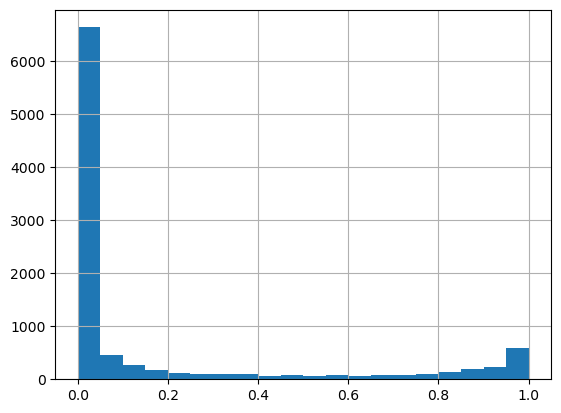

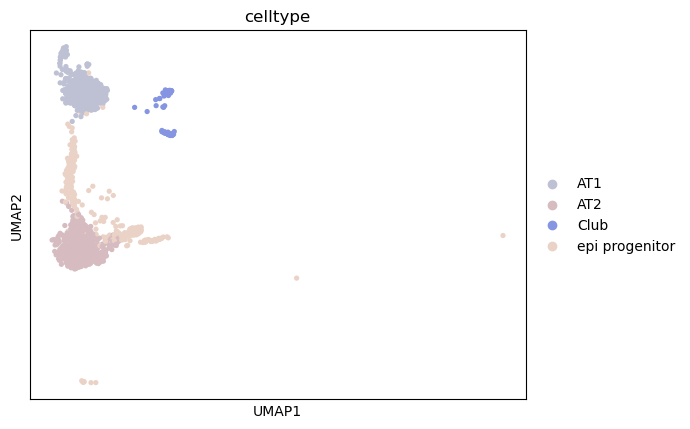

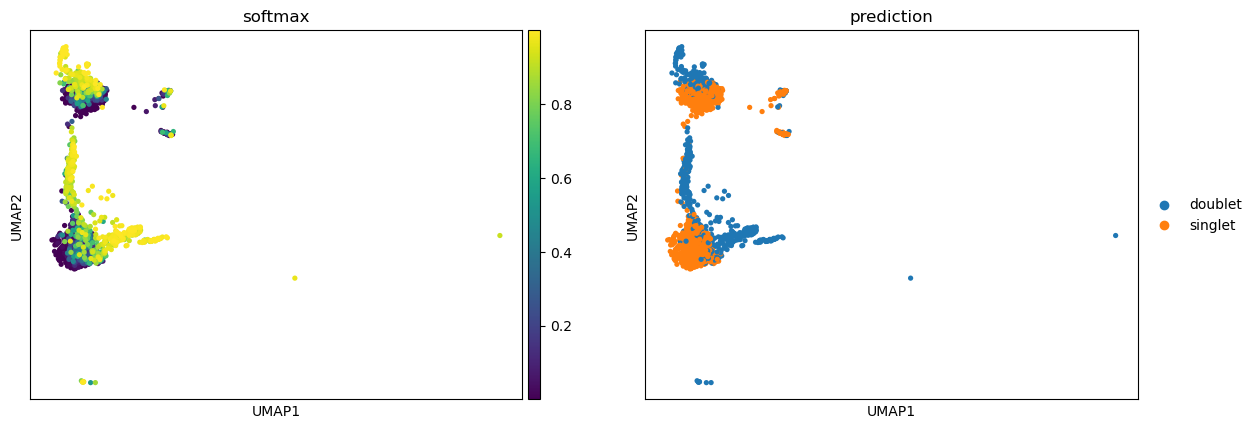

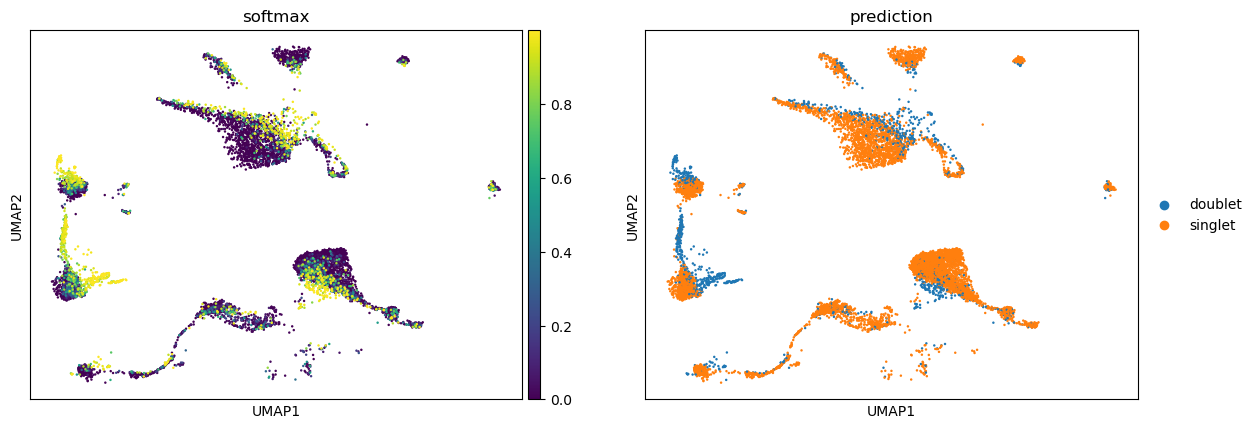

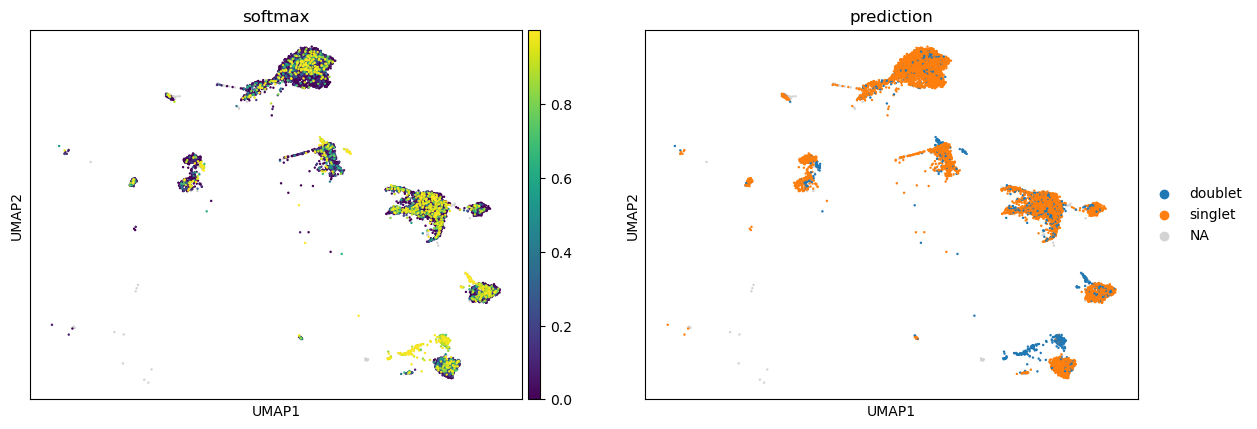

working on stage P7 

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 75/600:  12%|█▎        | 75/600 [07:42<53:58,  6.17s/it, v_num=1, train_loss_step=0.0344, train_loss_epoch=0.042]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.049. Signaling Trainer to stop.
prediction
singlet    7794
doublet    1806
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo             812     2893
epi              429     1181
mes              556     3666
other              9       54


/tmp/ipykernel_3100412/3641586752.py:28: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                  87      256
AT2                  62      749
Club                 24       45
epi progenitor      256      131


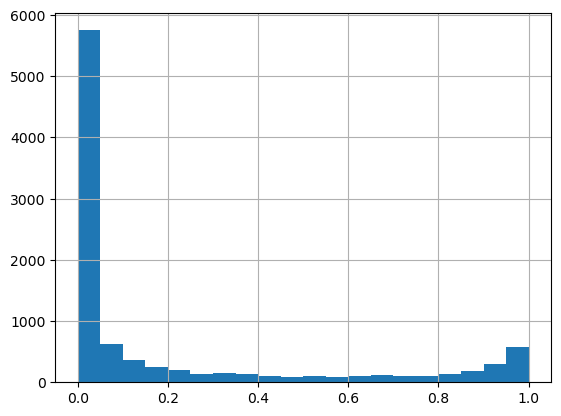

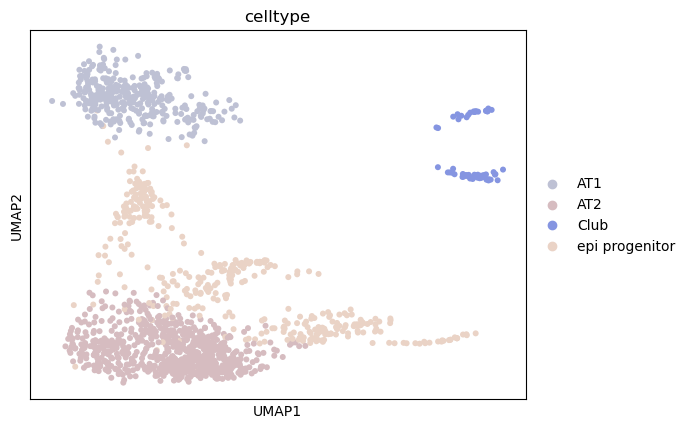

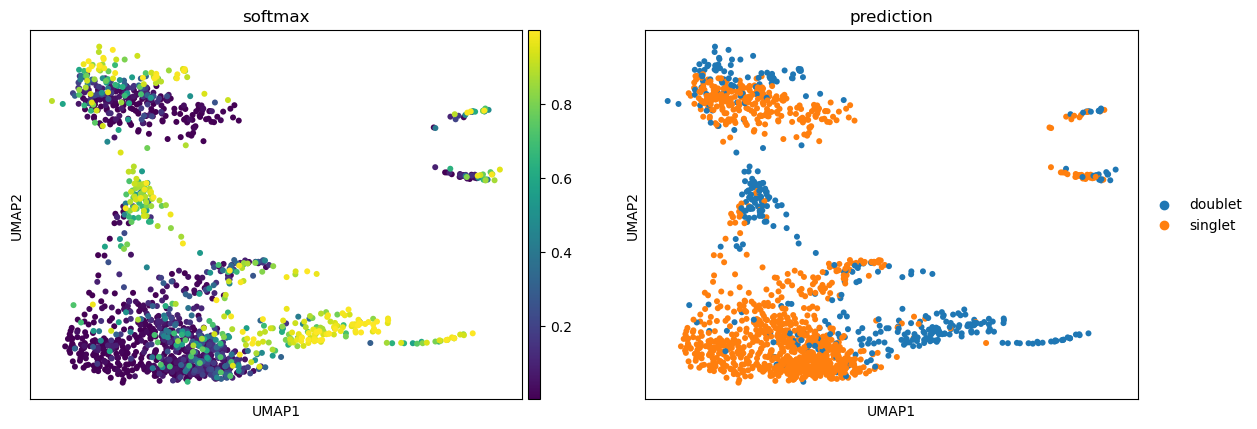

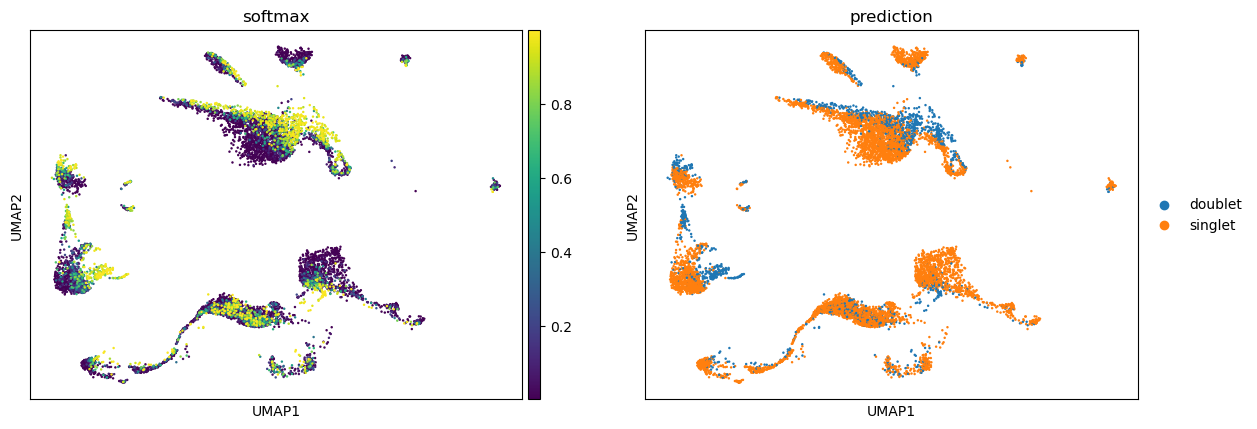

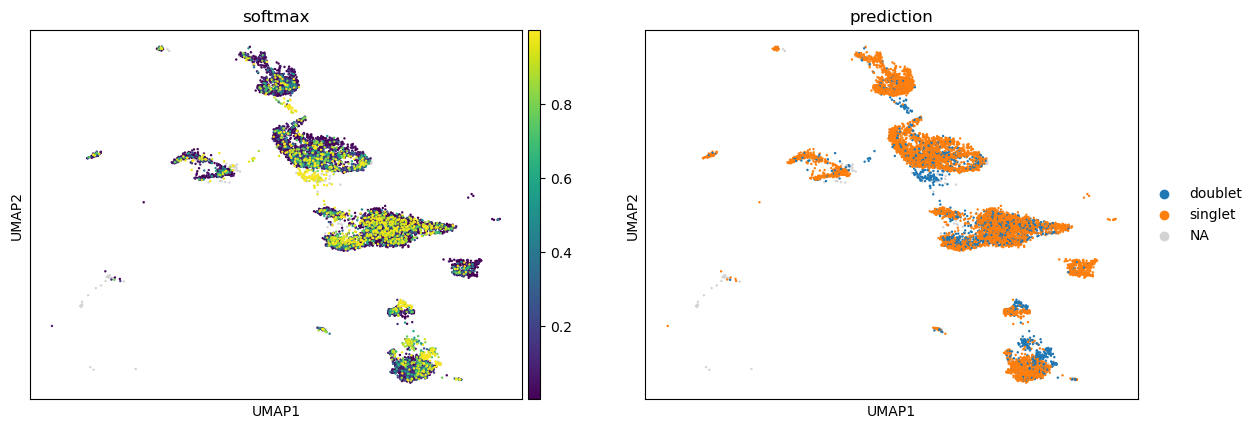

In [51]:

for stage in stages:
    print(f'working on stage {stage}', '\n')
    cells_mask = (adata.obs.development_stage==stage) & (adata.obs.compartment_cleaned != 'ambiguous')
    subdata = adata[cells_mask, adata.var.joint_highly_variable].copy()
    
    solo_batch = scvi.external.SOLO.from_scvi_model(
        vae, subdata, doublet_ratio=20, n_layers=2)

    solo_batch.train(accelerator='gpu', train_size=0.85, validation_size=0.15, batch_size=128, max_epochs=600)

    df = solo_batch.predict()
    df['softmax'] = np.exp(df['doublet'])/np.sum(np.exp(df[['singlet', 'doublet']]), axis=1)
    df['prediction'] = np.where(df['softmax'] > SOLO_THRESHOLD, 'doublet', 'singlet')

    print(df.prediction.value_counts())
    
    df.softmax.hist(bins=np.linspace(0,1,21))
    
    subdata.obs['prediction'] = df.prediction
    subdata.obs['softmax'] = df.softmax
    
    print(pd.crosstab(subdata.obs.compartment, subdata.obs.prediction))
    
    comp = 'epi'
    plot_dat = subdata[(subdata.obs.compartment==comp)]
    dat = vae_adata[adata.obs.development_stage==stage]
    
    dat.obs['softmax'] = df.softmax
    dat.obs['prediction'] = df.prediction
    
    print(pd.crosstab(plot_dat.obs.celltype, plot_dat.obs.prediction))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        sc.pl.umap(plot_dat, color=['celltype'])
        sc.pl.umap(plot_dat, color=['softmax', 'prediction'])
        sc.pl.umap(subdata, color=['softmax', 'prediction'])
        
        sc.pl.umap(dat, color=['softmax', 'prediction'])
    
    adata.obs.loc[subdata.obs_names, 'doublet_softmax'] = subdata.obs.softmax

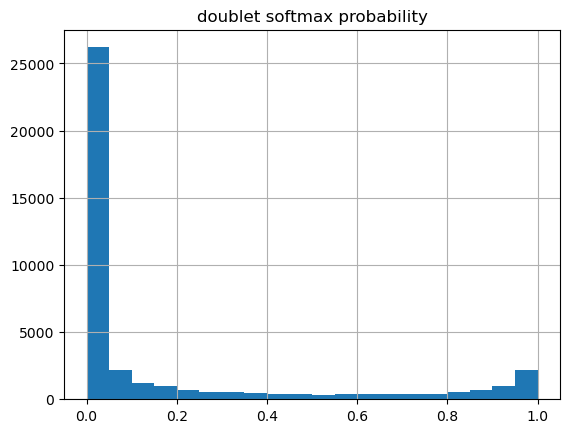

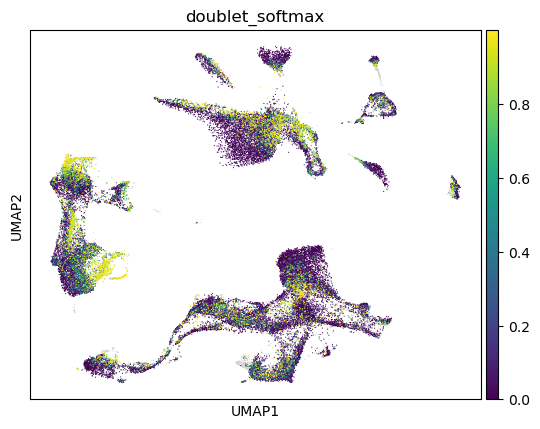

In [52]:
adata.obs['doublet_softmax'].hist(bins=np.linspace(0,1,21))
plt.title('doublet softmax probability')
sc.pl.umap(adata, color='doublet_softmax')

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



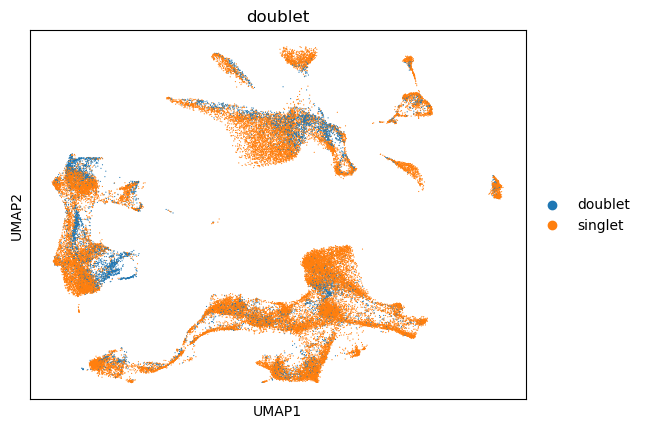

In [53]:
adata.obs['doublet'] = np.where(adata.obs['doublet_softmax'] > SOLO_THRESHOLD, 'doublet', 'singlet')
sc.pl.umap(adata, color='doublet')

In [54]:
adata.obs['doublet_softmax_r2'] = np.nan

working on stage E12
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 64/600:  11%|█         | 64/600 [03:43<31:12,  3.49s/it, v_num=1, train_loss_step=0.000357, train_loss_epoch=0.0125]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.018. Signaling Trainer to stop.
CPU times: user 4min 56s, sys: 2min 22s, total: 7min 18s
Wall time: 3min 44s
prediction
singlet    5841
doublet      95
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              10       86
epi               18      467
mes               48     5098
other             19      190


<timed exec>:29: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                   4      101
AT2                   1       46
Club                  3       92
epi progenitor       10      228


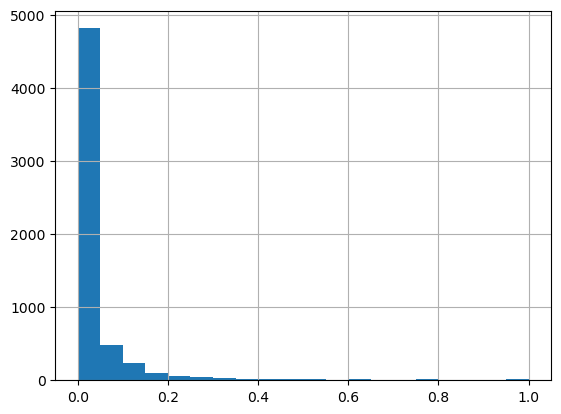

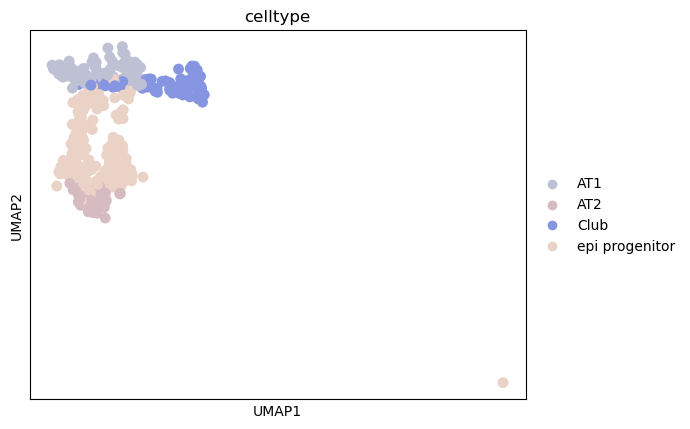

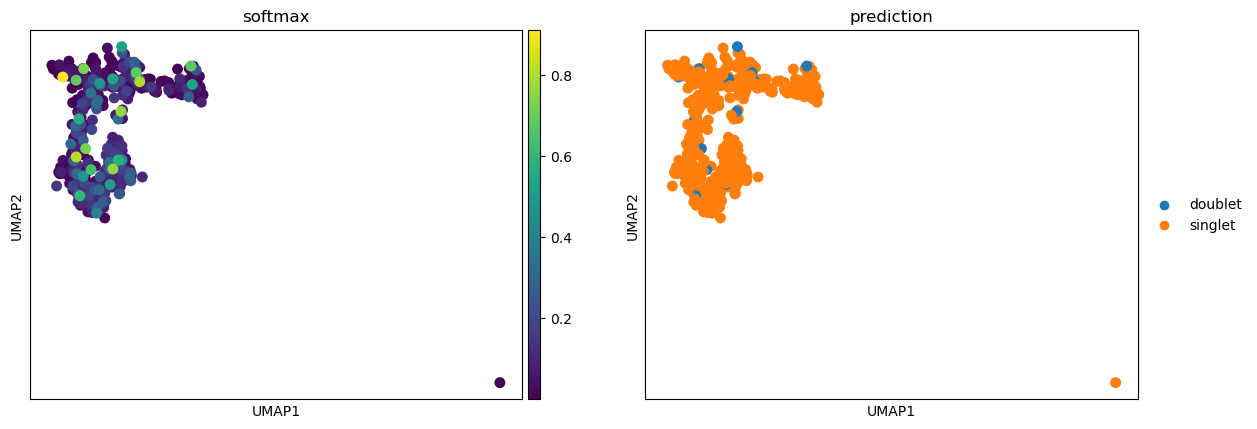

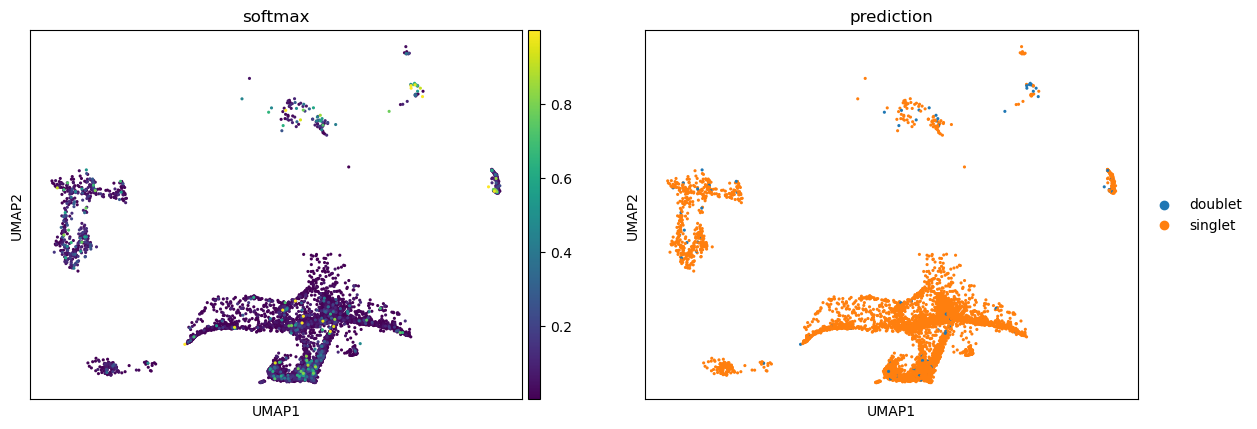

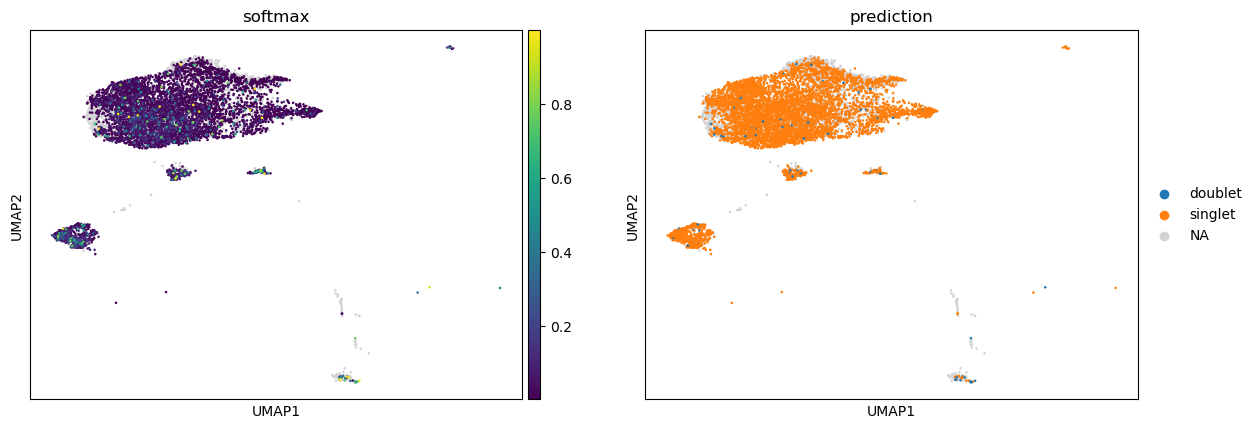

working on stage E15
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 99/600:  16%|█▋        | 99/600 [06:02<30:32,  3.66s/it, v_num=1, train_loss_step=0.00515, train_loss_epoch=0.0128] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.014. Signaling Trainer to stop.
CPU times: user 7min 55s, sys: 3min 41s, total: 11min 36s
Wall time: 6min 2s
prediction
singlet    5980
doublet     220
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              44      749
epi              128     2666
mes               35     1969
other             13      596


<timed exec>:29: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                  14      472
AT2                   0      234
Club                 22      288
epi progenitor       92     1672


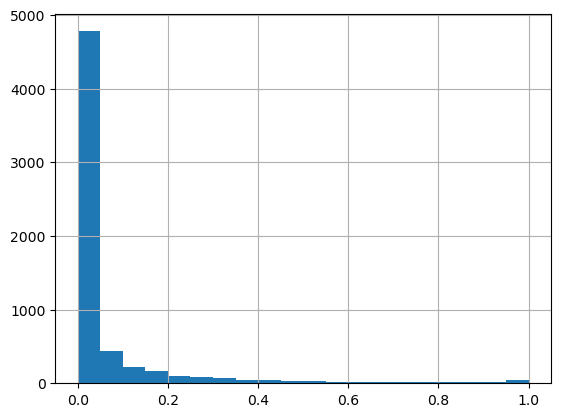

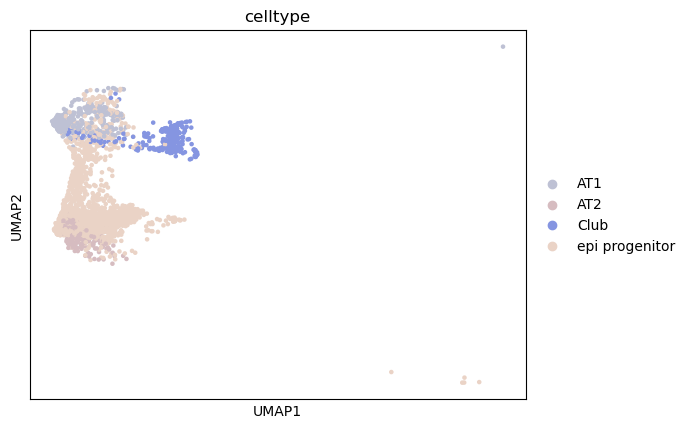

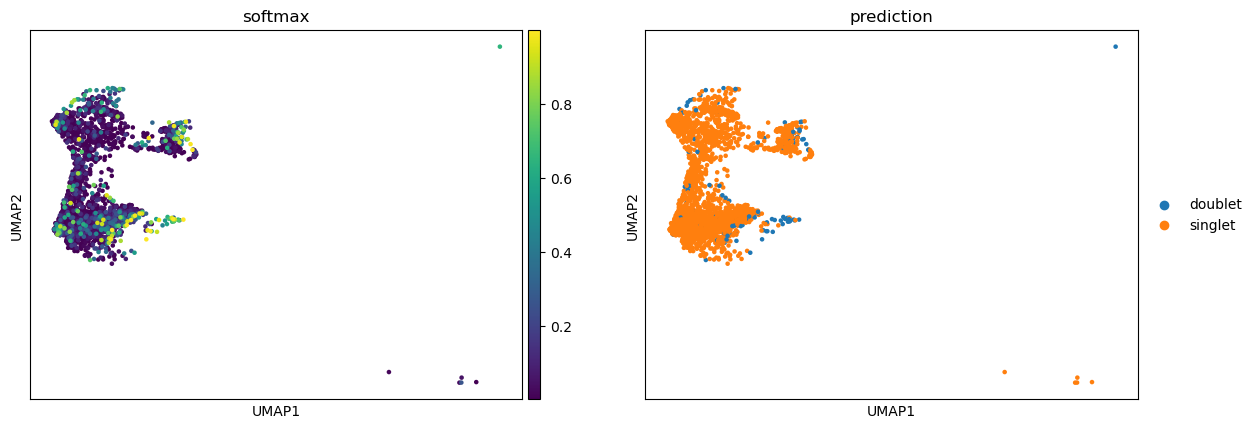

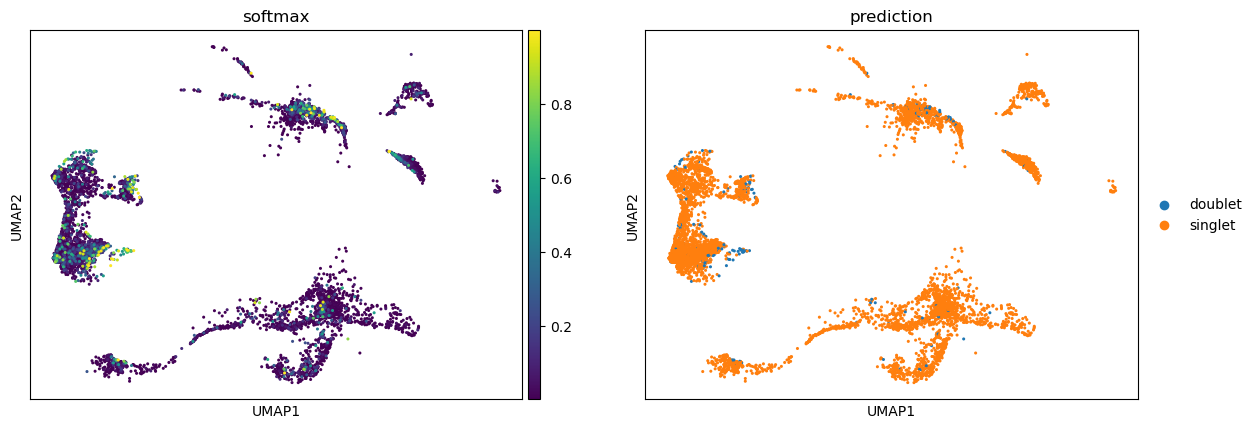

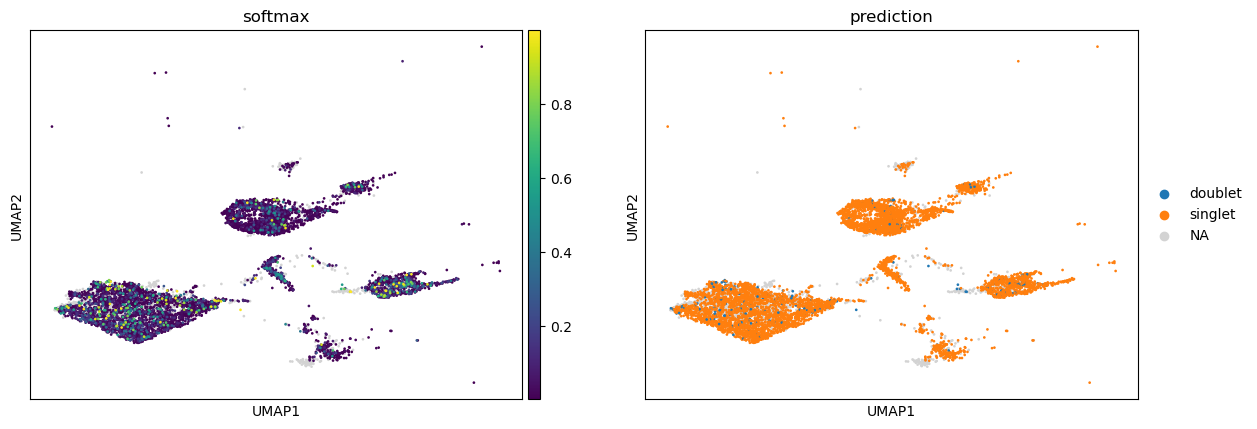

working on stage E17
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 106/600:  18%|█▊        | 106/600 [05:51<27:18,  3.32s/it, v_num=1, train_loss_step=0.0171, train_loss_epoch=0.00884]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.013. Signaling Trainer to stop.
CPU times: user 7min 52s, sys: 3min 56s, total: 11min 49s
Wall time: 5min 51s
prediction
singlet    5514
doublet      84
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              19     1208
epi               43     1857
mes                9     1755
other             13      694


<timed exec>:29: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                  16      593
AT2                   6      681
Club                  4      116
epi progenitor       17      467


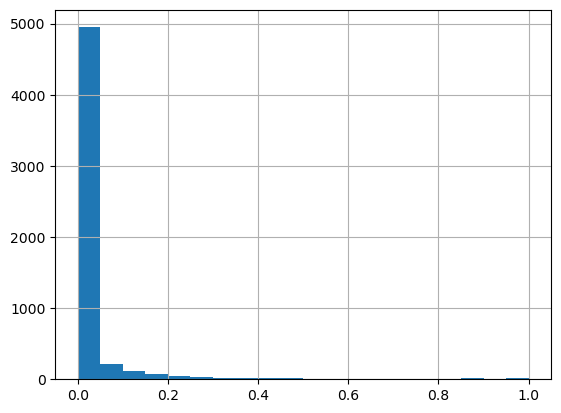

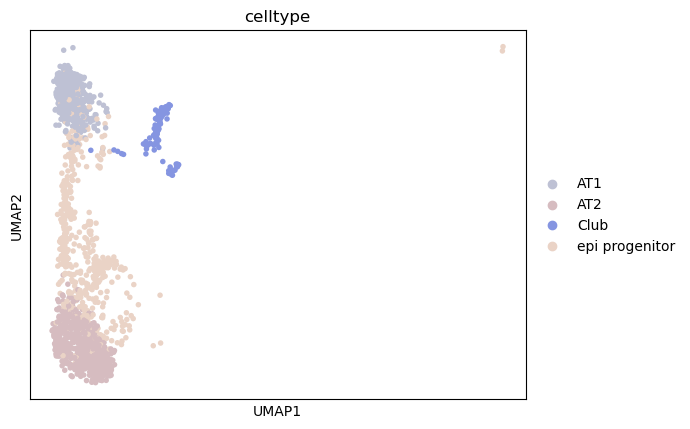

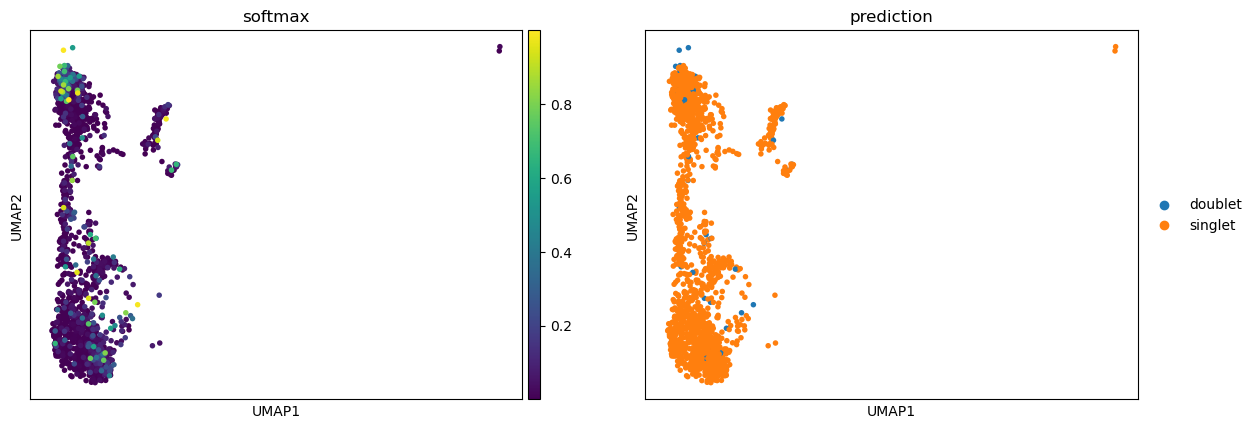

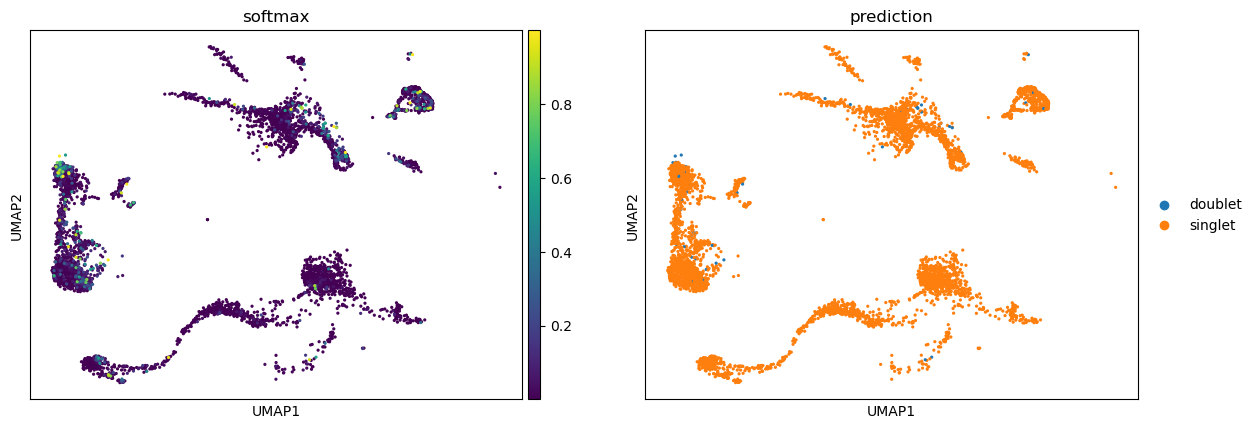

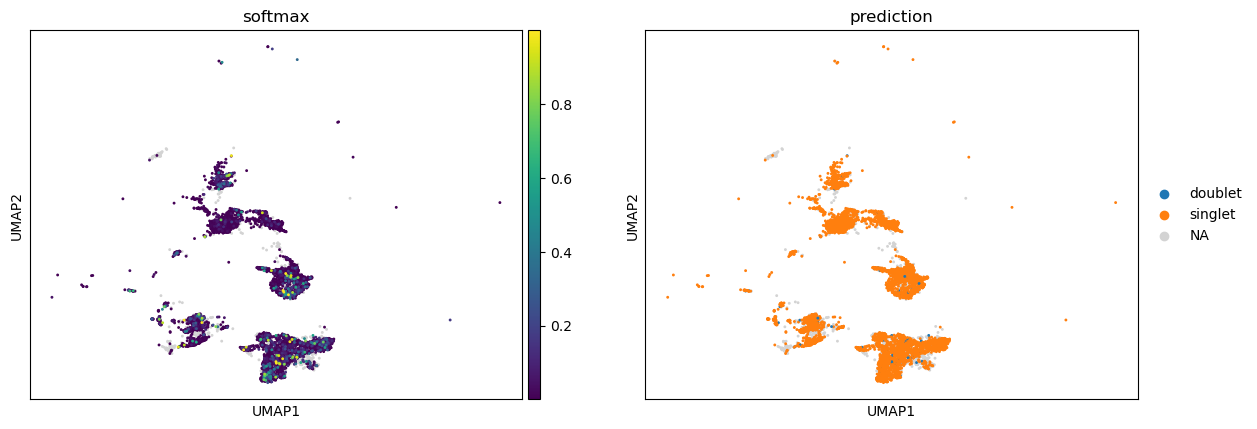

working on stage P3
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 77/600:  13%|█▎        | 77/600 [06:10<41:53,  4.81s/it, v_num=1, train_loss_step=0.0102, train_loss_epoch=0.00511]  
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.008. Signaling Trainer to stop.
CPU times: user 7min 36s, sys: 2min 52s, total: 10min 29s
Wall time: 6min 10s
prediction
singlet    8024
doublet      80
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              15     2188
epi               13     1434
mes               49     4312
other              3       90


<timed exec>:29: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                   6      658
AT2                   4      689
Club                  2       74
epi progenitor        1       13


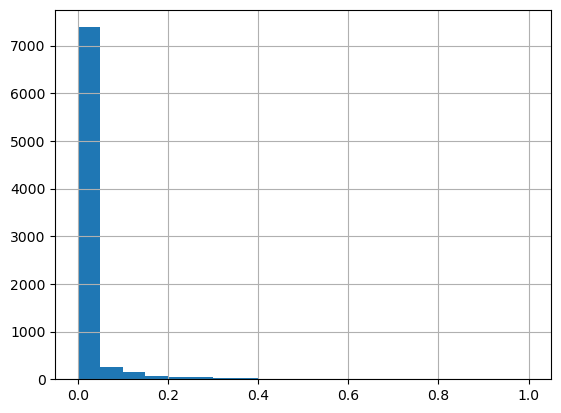

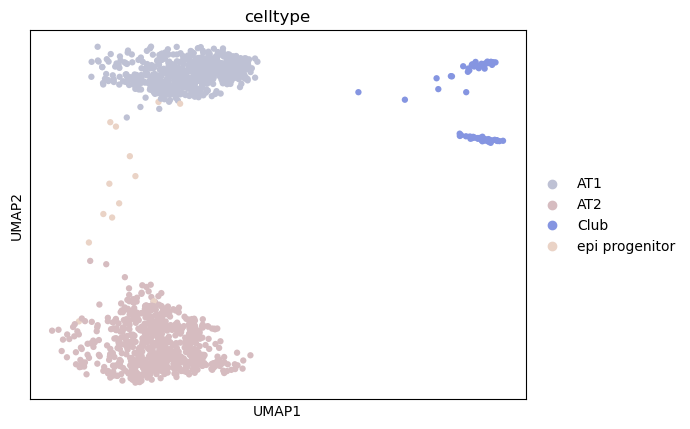

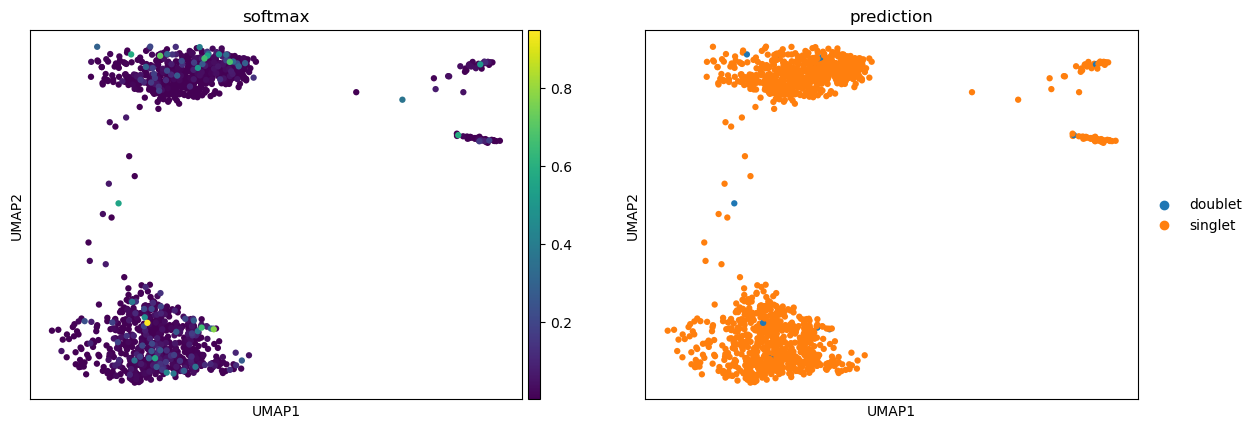

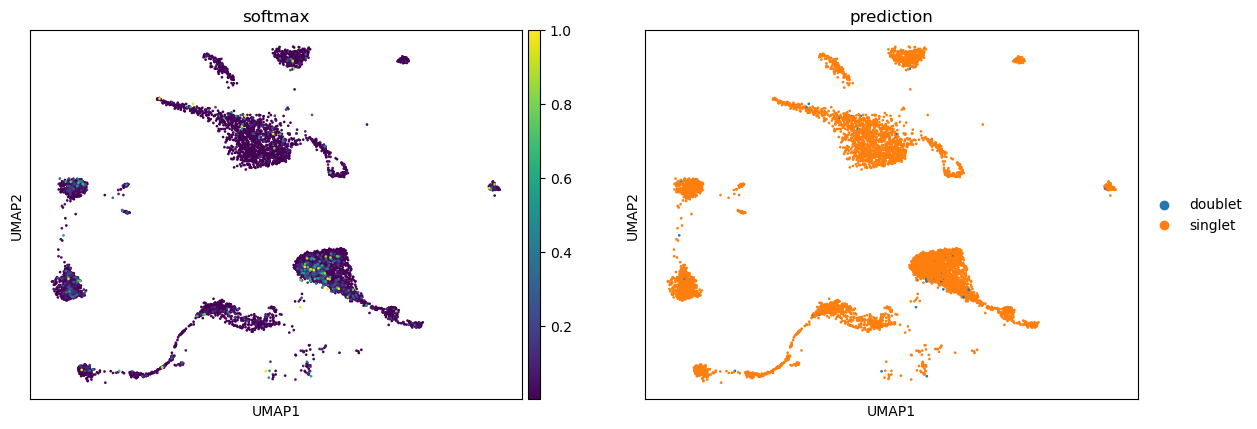

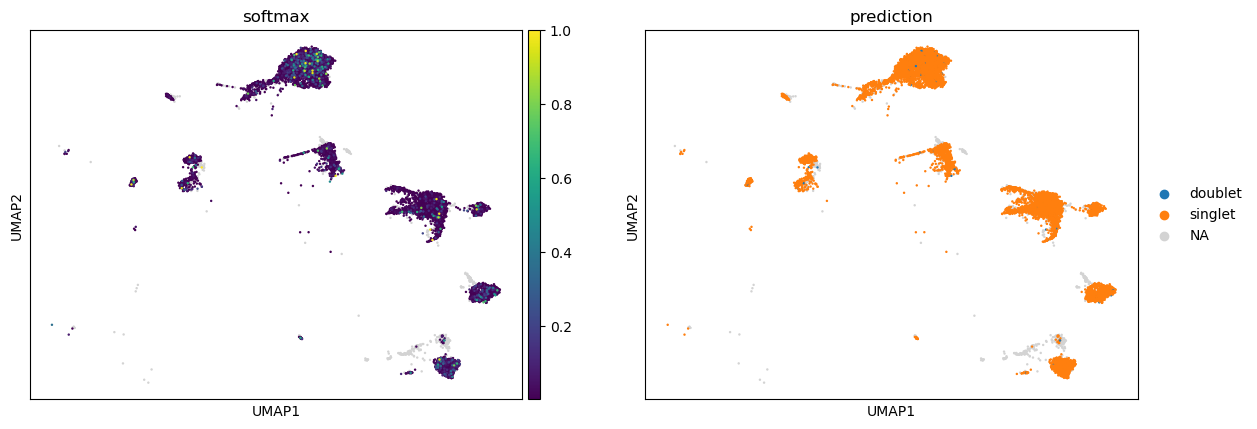

working on stage P7
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 97/600:  16%|█▌        | 97/600 [07:35<39:20,  4.69s/it, v_num=1, train_loss_step=0.0111, train_loss_epoch=0.011]   
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.018. Signaling Trainer to stop.
CPU times: user 9min 24s, sys: 3min 38s, total: 13min 2s
Wall time: 7min 35s
prediction
singlet    7591
doublet     203
Name: count, dtype: int64
prediction   doublet  singlet
compartment                  
endo              59     2834
epi               77     1104
mes               65     3601
other              2       52


<timed exec>:29: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



prediction      doublet  singlet
celltype                        
AT1                   5      251
AT2                  47      702
Club                  1       44
epi progenitor       24      107


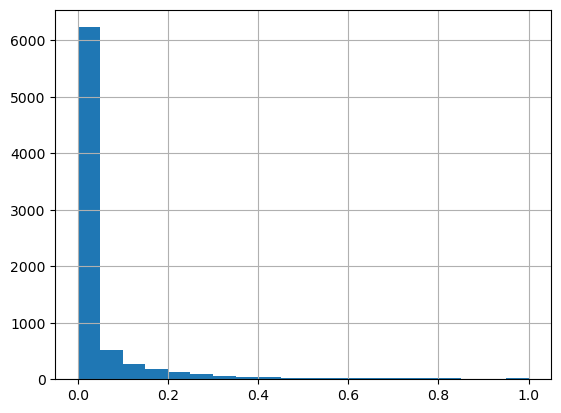

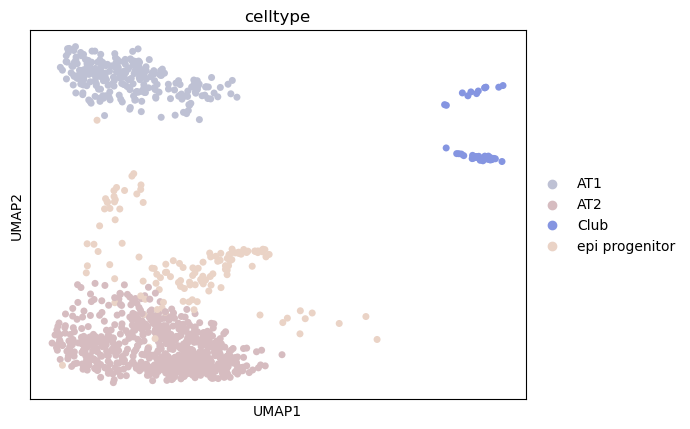

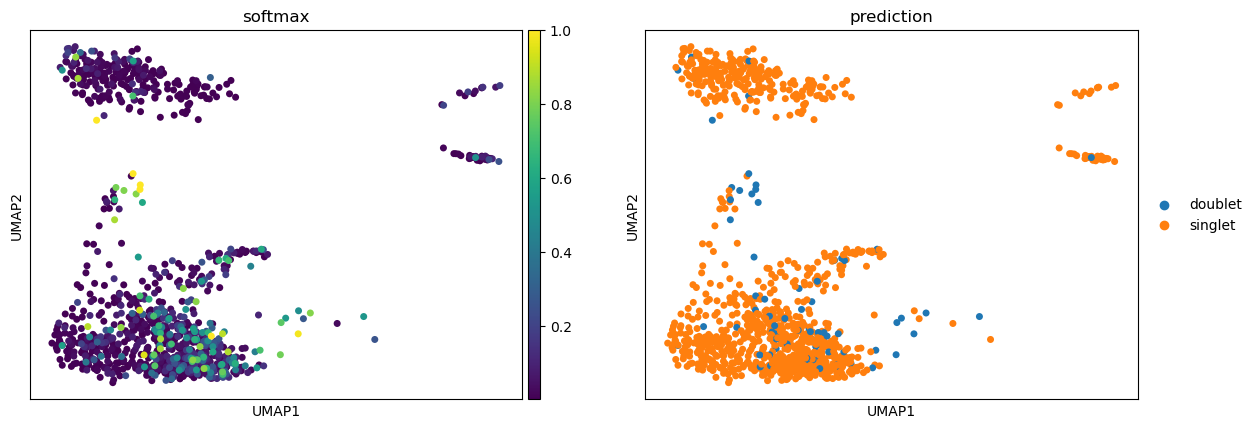

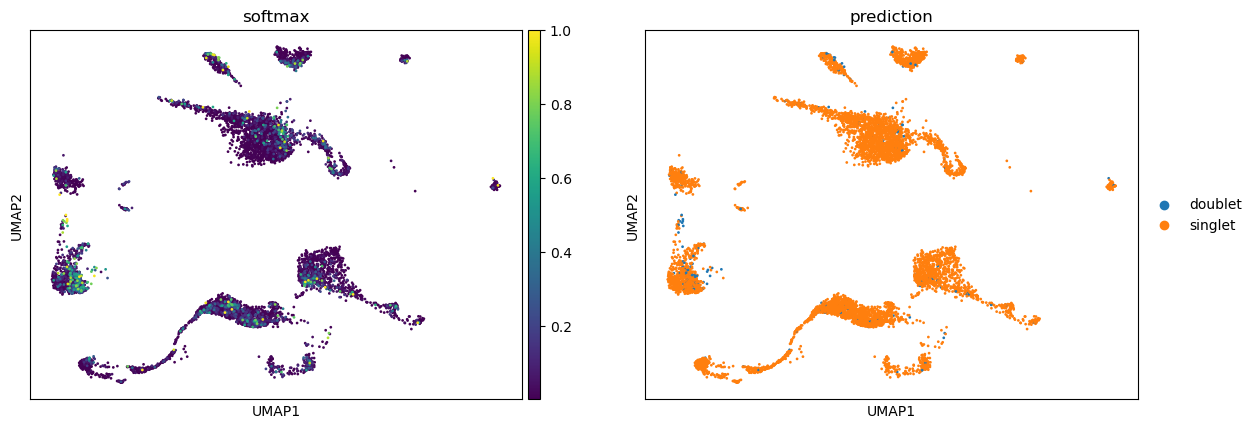

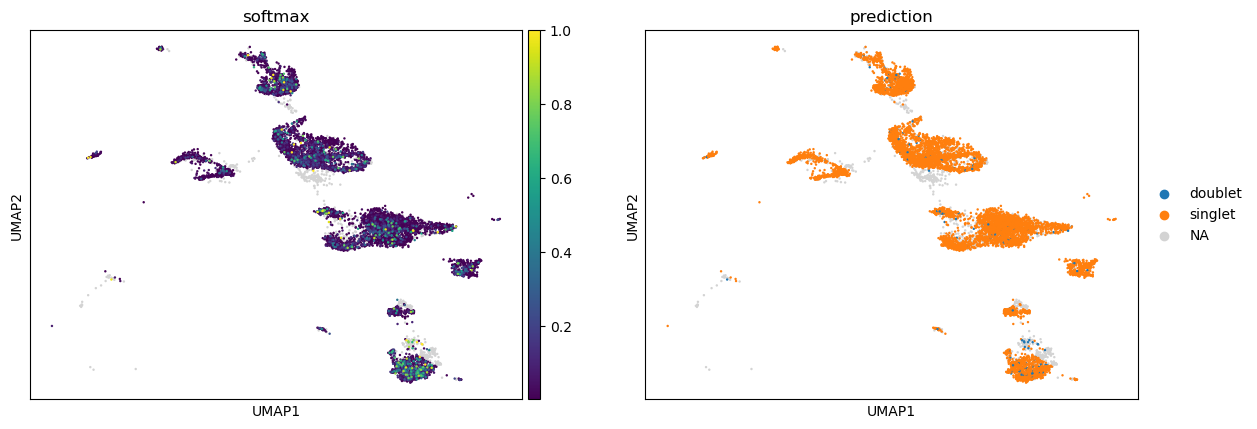

CPU times: user 38min 52s, sys: 16min 40s, total: 55min 32s
Wall time: 30min 33s


In [55]:
%%time
r2_data = adata[(adata.obs.doublet == 'singlet') & (adata.obs.compartment_cleaned != 'ambiguous')]

for stage in stages:
    print(f'working on stage {stage}')
    
    subdata = r2_data[r2_data.obs.development_stage==stage, r2_data.var.joint_highly_variable].copy()
    solo_batch = scvi.external.SOLO.from_scvi_model(
        vae, subdata.copy(), doublet_ratio=20, n_layers=2)

    %time solo_batch.train(accelerator='gpu', train_size=0.8, validation_size=0.1, batch_size=128, max_epochs=100)

    df = solo_batch.predict()
    df['softmax'] = np.exp(df['doublet'])/np.sum(np.exp(df[['singlet', 'doublet']]), axis=1)
    df['prediction'] = np.where(df['softmax'] > SOLO_THRESHOLD, 'doublet', 'singlet')

    print(df.prediction.value_counts())
    
    df.softmax.hist(bins=np.linspace(0,1,21))
    
    subdata.obs['prediction'] = df.prediction
    subdata.obs['softmax'] = df.softmax
    
    print(pd.crosstab(subdata.obs.compartment, subdata.obs.prediction))
    
    comp = 'epi'
    plot_dat = subdata[(subdata.obs.compartment==comp)]
    dat = vae_adata[adata.obs.development_stage==stage]
    
    dat.obs['softmax'] = df.softmax
    dat.obs['prediction'] = df.prediction
    
    print(pd.crosstab(plot_dat.obs.celltype, plot_dat.obs.prediction))

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")

        sc.pl.umap(plot_dat, color=['celltype'])
        sc.pl.umap(plot_dat, color=['softmax', 'prediction'])
        sc.pl.umap(subdata, color=['softmax', 'prediction'])
        
        sc.pl.umap(dat, color=['softmax', 'prediction'])
    
    adata.obs.loc[subdata.obs_names, 'doublet_softmax_r2'] = subdata.obs.softmax

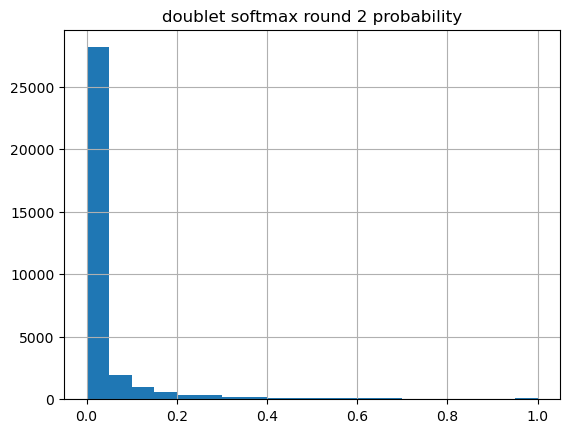

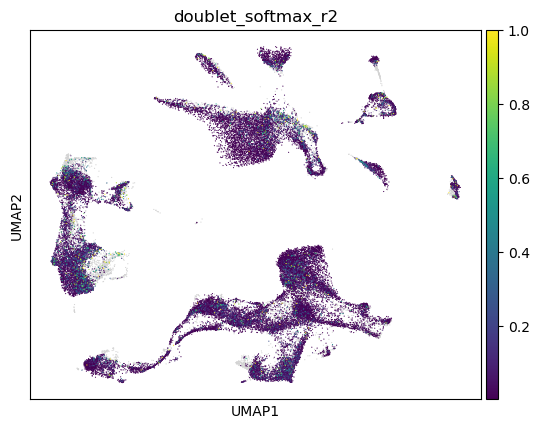

In [56]:
adata.obs['doublet_softmax_r2'].hist(bins=np.linspace(0,1,21))
plt.title('doublet softmax round 2 probability')
sc.pl.umap(adata, color='doublet_softmax_r2')

/cs/labs/mornitzan/yotamcon/conda/envs/pp_t/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



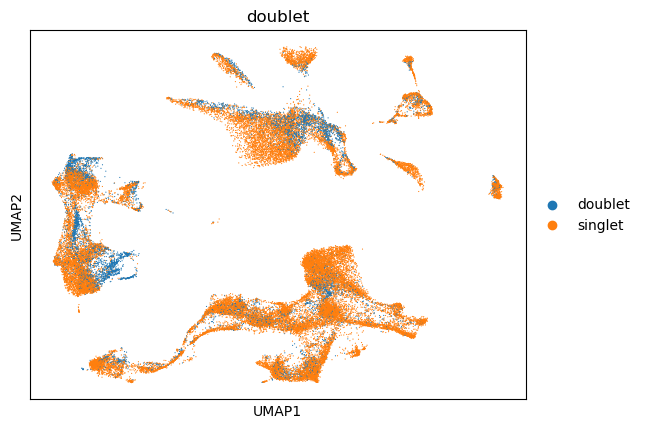

In [57]:
adata.obs['doublet'] = np.where((adata.obs['doublet_softmax'] > SOLO_THRESHOLD) | (adata.obs['doublet_softmax_r2'] > SOLO_THRESHOLD), 'doublet', 'singlet')
sc.pl.umap(adata, color='doublet')

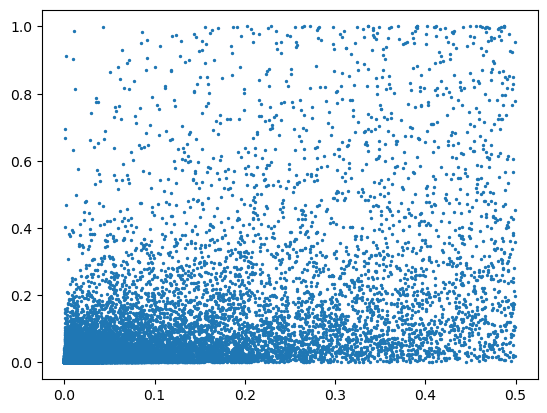

In [58]:
plt.scatter(adata.obs.doublet_softmax, adata.obs.doublet_softmax_r2, s=2)

In [59]:
no_doublets = adata[adata.obs.doublet == 'singlet']
no_doublets = no_doublets[no_doublets.obs.compartment_cleaned == 'epi']
pd.crosstab(no_doublets.obs.celltype, no_doublets.obs.development_stage)

development_stage  E12   E15  E17   P3   P7
celltype                                   
AT1                101   472  593  658  251
AT2                 46   234  681  689  702
Club                92   288  116   74   44
epi progenitor     228  1672  467   13  107

In [60]:
pd.crosstab(adata.obs.doublet, adata.obs.compartment_cleaned)

compartment_cleaned  ambiguous  endo   epi    mes  other
doublet                                                 
doublet                      0  1874  2923   2214    292
singlet                   3436  7065  7528  16735   1622

In [61]:
adata = adata[(adata.obs.doublet == 'singlet') & (adata.obs.compartment_cleaned != 'ambiguous' )]
adata.shape

(32950, 17197)

### Saving/loading the pre-processed object

In [3]:
%%time
pre_processed_adata_file = results_dir.joinpath('full.h5ad')

if not pre_processed_adata_file.exists():
    adata.write(pre_processed_adata_file)
else:
    adata = sc.read_h5ad(pre_processed_adata_file)
adata

CPU times: user 267 ms, sys: 396 ms, total: 663 ms
Wall time: 9.63 s


AnnData object with n_obs × n_vars = 32950 × 17197
    obs: 'development_stage', 'n_molecules', 'n_genes', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'var_time', 'cell_type', 'CellID', 'cell_names', 'celltype', 'compartment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'predP10', 'compartment_cleaned', 'predP10_twice', 'doublet_softmax', 'doublet', 'doublet_softmax_r2'
    var: 'name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'n_counts', 'development_stage_max_var_norm', 'joint_highly_variable'
    uns: 'celltype_colors', 'celltype_colors_dict', 'compartment_colors', 'compartment_colors_dict', 'development_stage_colors', 'development_stage_colors_dict', 'doublet_colors', 'neighbors'
    obsm: 'X_pca', 'X_scVI', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

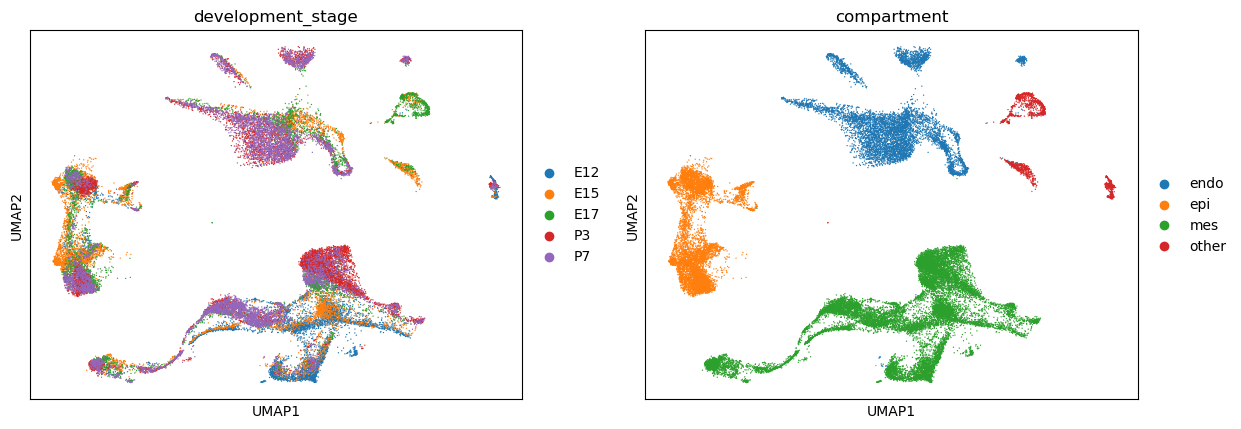

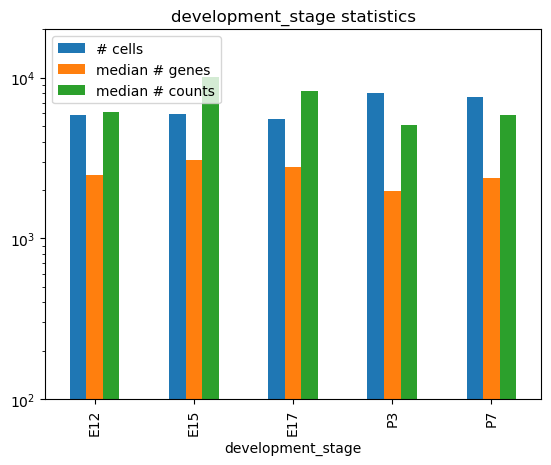

In [4]:
column_of_interest = 'development_stage'
color_obs_by = 'compartment'

with warnings.catch_warnings():  # supress scanpy plotting warning
    warnings.simplefilter(action='ignore', category=UserWarning)
    
    # umap by celltype:
    sc.pl.umap(adata, color=[column_of_interest, color_obs_by])
    
    # statistics
    stats_df = adata.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
        [column_of_interest]).median()
    
    stats_df = pd.concat([adata.obs.groupby([column_of_interest]).count().iloc[:, 0],
                          stats_df], axis=1)
    stats_df.columns = ['# cells', 'median # genes', 'median # counts']
    
    stats_df.plot(kind='bar', title=f'{column_of_interest} statistics', log=True, ylim=((1e2, 2e4)))
    plt.show()
    del stats_df

In [64]:
pd.crosstab(adata.obs.celltype, adata.obs.development_stage)

development_stage   E12   E15  E17    P3    P7
celltype                                      
AMP                 109   176  277   263   277
ASM_SCMF            583   196  373   592  1612
AT1                 101   472  593   658   251
AT2                  46   234  681   689   702
Cap EC               40   473  671  1245  1588
Car4 EC               0     0   29   315   393
Club                 92   288  116    74    44
Erythroid             0   354   56     0     0
Immune               13   223  637     0     0
Lymphatic EC          9     1    5    73    53
MANC                157    82   69   242   139
Mesothelial         177    19    1    90    52
VSM                  22    57   83   194   231
Wnt2-pa              39    81  747  2884   853
epi progenitor      228  1672  467    13   107
macro EC Arterial     0    15   76   187   175
macro EC Venous       0    33   53   137   191
mes progenitor     2249   996  119    61   264
prolif EC            37   227  374   231   434
prolif mes         1852   380   84    70   225
tracheal mes         87     1    3     6     0

## 3. Subsetting and splitting the dataset by stage, and selecting joint highly variable genes (HVG)
#### Cells filter:
1.  Epithelial (not including "Ciliated" as those were almost exclusively doublets and the "unknown 3" celltype)
2.  Stages E12-P7

#### Genes filter:
1.  Removing ribosomal genes
2.  Removing mitochondrial genes

Creating adata object split by developmental stage

In [20]:
%%time

subset_adata_file = results_dir.joinpath('epi_subset.h5ad')
column_of_interest = 'development_stage'
color_obs_by = 'celltype'

if not subset_adata_file.exists():
    subset = adata[(adata.obs.celltype.isin(['AT1', 'AT2', 'Club', 'epi progenitor'])) & \
    (adata.obs.development_stage.isin(['E12', 'E15', 'E17', 'P3', 'P7'])),
    ~(adata.var.name.str.contains('^mt-') |
      adata.var.name.str.contains('^Mrp[ls]\d') |
      adata.var.name.str.contains('^Rp[ls]\d'))].copy()

    # remove unutilized genes and recalculate counts statistics
    sc.pp.filter_genes(subset, min_cells=1)
    sc.pp.filter_genes(subset, min_counts=1)
    sc.pp.filter_cells(subset, min_genes=1)
    sc.pp.filter_cells(subset, min_counts=1)
    subset.obs.n_genes_by_counts = subset.obs.n_genes.copy()
    subset.obs.total_counts = subset.obs.n_counts.copy()

    sc.pp.highly_variable_genes(subset, flavor='seurat_v3', n_top_genes=5000)
    
    _utils.joint_hvg_across_stages(subset, obs_category_key=column_of_interest, n_top_genes=5000)

    # Generate new UMAP for remaining cells using BBKNN
    tmp = subset.copy()
    sc.pp.normalize_total(tmp, target_sum=5e3, exclude_highly_expressed=True)
    sc.pp.log1p(tmp)
    tmp.var['highly_variable'] = tmp.var['joint_highly_variable']
    sc.pp.pca(tmp, use_highly_variable=True)

    sc.external.pp.bbknn(tmp, batch_key="development_stage")
    sc.tl.umap(tmp)

    subset.obsm['X_umap'] = tmp.obsm['X_umap'].copy()
    subset.obsp['connectivities'] = tmp.obsp['connectivities'].copy()
    subset.obsp['distances'] = tmp.obsp['distances'].copy()
    subset.uns['neighbors'] = tmp.uns['neighbors']
    
    subset.write(subset_adata_file)
else:
    subset = sc.read_h5ad(subset_adata_file)

CPU times: user 136 ms, sys: 106 ms, total: 242 ms
Wall time: 2.65 s


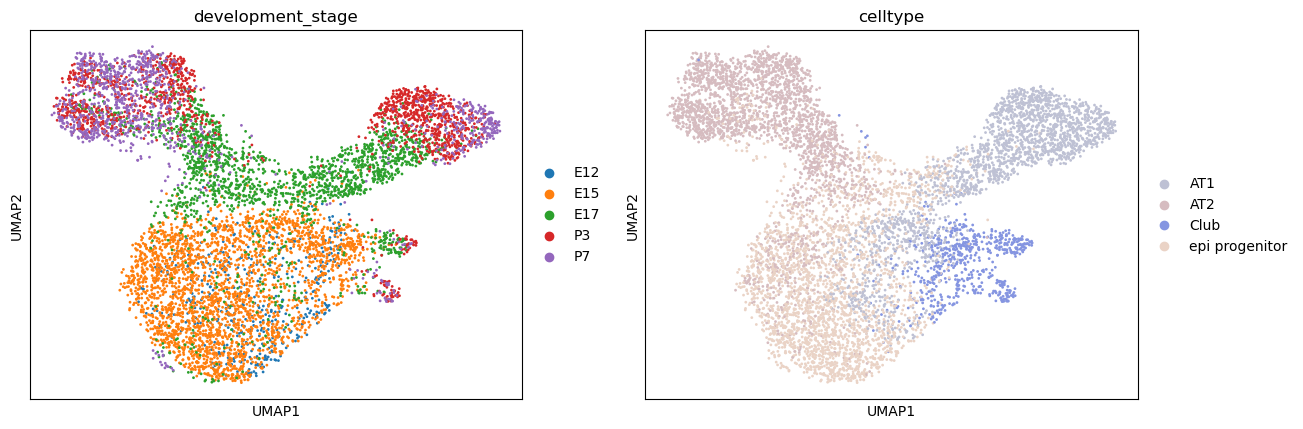

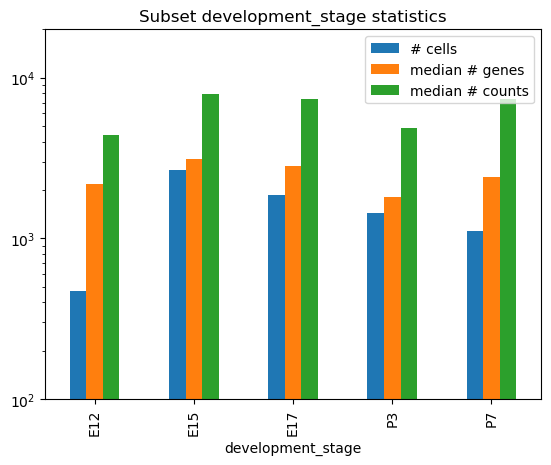

(7528, 16812)

In [22]:
with warnings.catch_warnings():  # supress scanpy plotting warning
    warnings.simplefilter(action='ignore', category=UserWarning)
    
    # umap by celltype:
    sc.pl.umap(subset, color=[column_of_interest, color_obs_by])
    
    # statistics
    stats_df = subset.obs.loc[:, [column_of_interest, 'n_genes', 'n_counts']].groupby(
        [column_of_interest]).median()
    
    stats_df = pd.concat([subset.obs.groupby([column_of_interest]).count().iloc[:, 0],
                          stats_df], axis=1)
    stats_df.columns = ['# cells', 'median # genes', 'median # counts']
    
    stats_df.plot(kind='bar', title=f'Subset {column_of_interest} statistics', log=True, ylim=((1e2, 2e4)))
    plt.show()
    del stats_df

subset.shape

In [ ]:
# Cell Cycle status
tmp = sc.read_h5ad(results_dir.joinpath("epi_subset.h5ad"))
sc.pp.normalize_total(tmp, target_sum=5e3, exclude_highly_expressed=True)
sc.pp.log1p(tmp)
with warnings.catch_warnings():  # supress plotting warnings
    warnings.simplefilter(action='ignore', category=UserWarning)
    sc.pl.stacked_violin(tmp, ['Top2a', 'Cdkn3', 'Mki67', 'Rrm2', 'Lig1'], groupby='development_stage')

del tmp
pd.crosstab(subset.obs.Phase, subset.obs.development_stage)

In [66]:
%%time

categories = subset.obs[column_of_interest].cat.categories

split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

for cat in categories:
    if not split_adatas_dir.joinpath(f'{cat}.h5ad').exists():
        print(f'working on {cat}')
        tmp = subset[subset.obs[column_of_interest] == cat].copy()

        tmp.uns['name'] = f'{cat}'   # full name
        tmp.uns['sname'] = f'{cat[:3]}'  # short name, here it is the same

        # correcting the gene counts
        sc.pp.filter_genes(tmp, min_cells=0)
        sc.pp.filter_genes(tmp, min_counts=0)
        sc.pp.highly_variable_genes(tmp, flavor='seurat_v3', n_top_genes=5000)

        tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

        del tmp
    else:
        print(f'{cat} split adata exists')

Directory "results/zepp/split_development_stage" does not exist.
trying to create it at /cs/labs/mornitzan/yotamcon/gep-dynamics/results/zepp/split_development_stage
working on E12
working on E15
working on E17
working on P3
working on P7
CPU times: user 4.35 s, sys: 385 ms, total: 4.74 s
Wall time: 5.14 s


## 4. Running consensus NMF iterations

In [7]:
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))
beta_loss = 'kullback-leibler'
tpm_target_sum = 5_000
nmf_iterations = 100

In [68]:
%%time

ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]#, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    tmp = sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    # Variance-capped normalized version of the data
    X = _utils.subset_and_normalize_for_nmf(tmp, method='variance_cap')
    
    c_object.prepare(X, ks, n_iter=nmf_iterations, new_nmf_kwargs={
        'tol': _constants.NMF_TOLERANCE, 'beta_loss': beta_loss, 'max_iter': 1000})
    
    c_object.factorize(0, 1, gpu=True)
    
    c_object.combine()
    
    del tmp, X

Starting on E12, time is 20:05:05
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on E15, time is 20:15:13
Combining factorizations for k=1.
Combining factorizations for k=2.
Combining factorizations for k=3.
Combining factorizations for k=4.
Combining factorizations for k=5.
Combining factorizations for k=6.
Combining factorizations for k=7.
Combining factorizations for k=8.
Combining factorizations for k=9.
Combining factorizations for k=10.
Combining factorizations for k=11.
Combining factorizations for k=12.
Starting on E17, time is 20:39:59
Combining factorizations for k=1.
Combining factorizations for k=2.
Combinin

In [69]:
%%time
thresh = 0.5

for cat in categories:
    print(f'Starting on {cat}, time is {time.strftime("%H:%M:%S", time.localtime())}')
    c_object = cnmf.cNMF(cnmf_dir, cat)

    c_object.k_selection_plot(density_threshold=thresh, nmf_refitting_iters=1000, 
                              consensus_method='mean',
                              close_fig=True, show_clustering=True, gpu=True)
    # printing the selected knee point
    df = cnmf.load_df_from_npz(c_object.paths['k_selection_stats_dt'] % c_object.convert_dt_to_str(thresh))
    pos = len(df) - 4
    for i in range(4 + 1):
        print(cnmf.find_knee_point(df.prediction_error[:pos + i], df.k_source[:pos + i]), end=", ")
    print()

Starting on E12, time is 21:19:30
4.0, 4.0, 4.0, 5.0, 5.0, 
Starting on E15, time is 21:20:32
3.0, 4.0, 4.0, 5.0, 5.0, 
Starting on E17, time is 21:21:33
4.0, 4.0, 4.0, 4.0, 4.0, 
Starting on P3, time is 21:22:30
3.0, 3.0, 3.0, 3.0, 3.0, 
Starting on P7, time is 21:23:28
3.0, 3.0, 3.0, 3.0, 4.0, 
CPU times: user 14min 31s, sys: 16min 30s, total: 31min 2s
Wall time: 4min 51s


## 5. Selecting decomposition rank for cNMF using knee-point, silhouette and rank dynamics

In [29]:
column_of_interest = 'development_stage'
color_obs_by = 'celltype'
cnmf_dir = _utils.set_dir(results_dir.joinpath('cnmf'))


if 'subset' not in globals():
    subset_adata_file = results_dir.joinpath('epi_subset.h5ad')
    subset = sc.read_h5ad(subset_adata_file)

if 'categories' not in globals():
    categories = subset.obs[column_of_interest].cat.categories

if 'split_adatas' not in globals():
    split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

    split_adatas = {}
    for cat in categories:
        split_adatas[cat] =  sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

if 'decompositions' not in globals():
    decompositions = {}
    for cat in categories:
        decompositions[cat] = {}

#### Calculating decompositions for a range of ranks around the relevant values

In [30]:
%%time
threshold = 0.5

k_min = 3
k_max = 9

for cat in categories:
    print(f'Working on {cat}')
    tmp = split_adatas[cat]
    
    c_object = cnmf.cNMF(cnmf_dir, cat)
    
    for k in range(k_min, k_max + 1):
        if k in decompositions[cat].keys():
            continue

        print(f'processing k={k}')
        try:
            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
        except FileNotFoundError:
            print(f'Calculating consensus NMF for k={k}')
            c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                               consensus_method='mean',
                               nmf_refitting_iters=1000, show_clustering=False)

            usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

        X = cnmf.load_data_from_npz(c_object.paths['data'])
        # X ~ W @ H, transpose for cells to be columns
        loss_per_cell = pfnmf.calc_beta_divergence(
            X.T, W = spectra.T, H = usages.T, per_column=True)
    
        res = comparator.NMFResult(
            name=f'{tmp.uns["sname"]}_k{k}',
            loss_per_cell=loss_per_cell,
            rank=k,
            W=usages,
            H=spectra)
        
        comparator.NMFResultBase.calculate_gene_coefficients_list(
            tmp, [res], target_sum=tpm_target_sum, target_variance=tmp.var['variances_norm'].values)
        
        decompositions[cat][k] = res
    
    print()

np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)

Working on E12

Working on E15

Working on E17

Working on P3

Working on P7

CPU times: user 30.8 ms, sys: 15.6 ms, total: 46.4 ms
Wall time: 396 ms


### Examining results

In [31]:
decomposition_images = _utils.set_dir(split_adatas_dir.joinpath("decompositions"))

tsc_threshold: float = 0.35
tsc_truncation_level: int = 500

for cat in categories:
    results = [decompositions[cat][i] for i in range(k_min, k_max + 1)]
    names_list = [res.name.split('_')[1] for res in results]
    ks, joint_names, joint_usages, joint_labels = comparator.NMFResultBase.aggregate_results(results)
    prog_names_dict = {res.name.split('_')[1]: [name.split('_')[1] for name in res.prog_names] for res in results}
    joint_names = [name.split('_')[1] for name in joint_names]
    
    # genes flow graph
    genes_title = f'{cat} flow chart of gene coefficients correlations for different decomposition ranks'
    genes_filename = f'{cat}_flow_chart_genes_by_rank.png'
    
    tsc = _utils.truncated_spearmans_correlation(pd.concat(
        [res.gene_coefs for res in results], axis = 1),
        truncation_level = tsc_truncation_level, rowvar = False)
    
    genes_adjacency = plotting.get_ordered_adjacency_matrix(
        tsc, joint_names, ks, tsc_threshold, verbose = True)
    
    fig = plotting.plot_layered_correlation_flow_chart(
        names_list, genes_adjacency, prog_names_dict, genes_title, layout_type='fan')
    
    fig.savefig(decomposition_images.joinpath(genes_filename))
    
    plt.close()

    # CDF of correlations
    plt.ecdf(tsc.flatten())
    plt.title(f'{cat}_flow_correlations_CDF.png')
    plt.savefig(decomposition_images.joinpath(f'{cat}_flow_correlations_CDF.png'))
    plt.close()

Number of edges=70
Number of edges=78
Number of edges=74
Number of edges=90
Number of edges=70


In [42]:
color_obs_by = 'celltype'

# Proximal: "Sox2", "Tspan1"
# Club: "Cyp2f2", "Scgb3a1",
# Ciliated: "Rsph1", "Foxj1"
# Distal: "Sox9", "Hopx"
# AT1: "Timp3", 'Aqp5'  
# AT2: 'Sftpa1', 'Sftpb'
# Cell Cycle: "Mki67", "Cdkn3", "Rrm2", "Lig1"
# Lineage markers: "Fxyd3", "Epcam", "Elf3", "Col1a2", "Dcn", "Mfap4", "Cd53", "Coro1a", "Ptprc", "Cldn5", "Clec14a", "Ecscr" 

marker_genes = ["Sox2", "Tspan1", "Cyp2f2", "Scgb3a1", "Rsph1", "Foxj1",
               "Sox9", "Hopx", "Timp3", 'Aqp5', 'Sftpa1', 'Sftpb',
               "Mki67", "Cdkn3", "Rrm2", "Lig1"]

with warnings.catch_warnings():  # supress plotting warnings
    warnings.simplefilter(action='ignore', category=UserWarning)

    for cat in categories:
        tmp = split_adatas[cat]
        for k in range(k_min, k_max + 1):
            res = decompositions[cat][k]
    
            # usages clustermap
            un_sns = _utils.plot_usages_norm_clustermaps(
                tmp, normalized_usages=res.norm_usages, prog_names=res.prog_names,
                title=f'{cat}', show=False, sns_clustermap_params={
                    'row_colors': tmp.obs[color_obs_by].map(tmp.uns[f'{color_obs_by}_colors_dict'])})
            un_sns.savefig(decomposition_images.joinpath(f"{cat}_{k}_usages_norm.png"),
                           dpi=180, bbox_inches='tight')
            plt.close(un_sns.fig)
    
            # usages violin plot
            _utils.plot_usages_norm_violin(
                tmp, color_obs_by, normalized_usages=res.norm_usages, prog_names=res.prog_names,
                save_path=decomposition_images.joinpath(
                    f'{cat}_{k}_norm_usage_per_lineage.png'))

            # Marker genes heatmap
            hm = sns.heatmap(res.gene_coefs.loc[marker_genes].T, cmap='coolwarm', vmin=-2, vmax=2)
            plt.tight_layout()
            hm.figure.savefig(decomposition_images.joinpath(f'{cat}_{k}_marker_genes.png'))
            plt.close()

        # UMAP of cells
        um = sc.pl.umap(tmp, color=color_obs_by, s=10, return_fig=True, title=f'{cat} epithelial')
        plt.tight_layout()
        um.savefig(decomposition_images.joinpath(f"{cat}_umap_{color_obs_by}.png"), dpi=300)
        plt.close(um)

### Selecting final parameters

In [23]:
decompositions = np.load(results_dir.joinpath('decompositions.npz'), allow_pickle=True)['obj'].item()
decompositions

{'E12': {3: <gepdynamics.comparator.NMFResult at 0x7f8def398a60>,
  4: <gepdynamics.comparator.NMFResult at 0x7f8defba0970>,
  5: <gepdynamics.comparator.NMFResult at 0x7f8defa4da90>,
  6: <gepdynamics.comparator.NMFResult at 0x7f8defa4d610>,
  7: <gepdynamics.comparator.NMFResult at 0x7f8defc760d0>,
  8: <gepdynamics.comparator.NMFResult at 0x7f8def42e6d0>,
  9: <gepdynamics.comparator.NMFResult at 0x7f8deeaf4ee0>},
 'E15': {3: <gepdynamics.comparator.NMFResult at 0x7f8defdae640>,
  4: <gepdynamics.comparator.NMFResult at 0x7f8de59d2070>,
  5: <gepdynamics.comparator.NMFResult at 0x7f8de5a05460>,
  6: <gepdynamics.comparator.NMFResult at 0x7f8de5a084f0>,
  7: <gepdynamics.comparator.NMFResult at 0x7f8de5a08100>,
  8: <gepdynamics.comparator.NMFResult at 0x7f8de59a74f0>,
  9: <gepdynamics.comparator.NMFResult at 0x7f8de59a7160>},
 'E17': {3: <gepdynamics.comparator.NMFResult at 0x7f8de59a76d0>,
  4: <gepdynamics.comparator.NMFResult at 0x7f8de59a73a0>,
  5: <gepdynamics.comparator.NMFR

In [5]:
thresh = 0.5
selected_cnmf_params = {
    'E12': (5, 0.5),
    'E15': (5, 0.5),
    'E17': (5, 0.5),
    'P3': (5, 0.5),
    'P7': (5, 0.5)}

selected_cnmf_params

{'E12': (5, 0.5),
 'E15': (5, 0.5),
 'E17': (5, 0.5),
 'P3': (5, 0.5),
 'P7': (5, 0.5)}

In [8]:
%%time

for cat, (k, threshold) in selected_cnmf_params.items():
    print(f'Working on {cat} with k={k} and threshold={threshold}')

    tmp = split_adatas[cat]
    
    c_object = cnmf.cNMF(cnmf_dir, cat)

    try:
        usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
    except FileNotFoundError:
        print(f'Calculating consensus NMF for k={k}')
        c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                           consensus_method='mean',
                           nmf_refitting_iters=1000, show_clustering=False)

        usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
    
    tmp.uns['cnmf_params'] = {'k_nmf': k, 'threshold': threshold}

    if k not in decompositions[cat]:
        X = cnmf.load_data_from_npz(c_object.paths['data'])
        
        # X ~ W @ H, transpose for cells to be columns
        loss_per_cell = pfnmf.calc_beta_divergence(
            X.T, W = spectra.T, H = usages.T, beta_loss=beta_loss, per_column=True)
    
        res = comparator.NMFResult(
            name=f'{tmp.uns["sname"]}_k{k}',
            loss_per_cell=loss_per_cell,
            rank=k,
            W=usages,
            H=spectra)
        
        comparator.NMFResultBase.calculate_gene_coefficients_list(
            tmp, [res], target_sum=tpm_target_sum, target_variance=tmp.var['variances_norm'].values)
    
        decompositions[cat][k] = res

    tmp.write_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

    print()

np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)

Working on E12 with k=5 and threshold=0.5

Working on E15 with k=5 and threshold=0.5

Working on E17 with k=5 and threshold=0.5

Working on P3 with k=5 and threshold=0.5

Working on P7 with k=5 and threshold=0.5

CPU times: user 929 ms, sys: 227 ms, total: 1.16 s
Wall time: 3.22 s


In [9]:
for cat in categories:
    print(cat)
    res = decompositions[cat][split_adatas[cat].uns['cnmf_params']['k_nmf']]
    with np.printoptions(precision=2, suppress=False):
        print(res.prog_percentages)

E12
[14.83 20.53 16.38 28.74 19.53]
E15
[ 8.6  29.93 33.22 12.05 16.22]
E17
[26.16 32.29 30.98  6.61  3.96]
P3
[ 2.91  2.97 41.7  10.85 41.57]
P7
[24.51  2.96  9.34 59.69  3.49]


## 6. Running comparator on the data


In [70]:
%%time 
# loading general variables

if 'results_dir' not in globals():
    results_dir = _utils.set_dir('results')
    results_dir = _utils.set_dir(results_dir.joinpath('zepp'))

if 'column_of_interest' not in globals():
    column_of_interest = 'development_stage'

if 'categories' not in globals():
    categories = ['E12', 'E15', 'E17', 'P3', 'P7']

if 'split_adatas' not in globals():
    split_adatas_dir = _utils.set_dir(results_dir.joinpath(f'split_{column_of_interest}'))

    split_adatas = {}
    for cat in categories:
        split_adatas[cat] =  sc.read_h5ad(split_adatas_dir.joinpath(f'{cat}.h5ad'))

if 'decompositions' not in globals():
    decompositions = np.load(results_dir.joinpath('decompositions.npz'), allow_pickle=True)['obj'].item()

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.44 µs


In [39]:
# Adding coloring of data rows by cell type

for cat in categories:
    tmp = split_adatas[cat]

    field_1 = 'celltype'

    tmp.obsm['row_colors'] = pd.concat([
        tmp.obs[field_1].map(tmp.uns[f'{field_1}_colors_dict']),
        ], axis=1)

In [41]:
%%time

pairs = [(categories[i], categories[i + 1]) for i in range(len(categories) - 1)]

pairs.extend((j, i) for i, j in pairs[::-1])

marker_genes = ["Sox2", "Tspan1", "Cyp2f2", "Scgb3a1", "Rsph1", "Foxj1",
               "Sox9", "Hopx", "Timp3", 'Aqp5', 'Sftpa1', 'Sftpb',
               "Mki67", "Cdkn3", "Rrm2", "Lig1"]


for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"comparator_{cat_a}_{cat_b}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
    else:
        cmp = comparator.Comparator(
            comparison_dir, adata_a, decompositions[cat_a][adata_a.uns['cnmf_params']['k_nmf']],
            max_added_rank=1,
            highly_variable_genes_key='joint_highly_variable',
            adata_b=adata_b, usages_matrix_b=decompositions[cat_b][adata_b.uns['cnmf_params']['k_nmf']],
            tpm_target_sum=tpm_target_sum,
            nmf_engine='torchnmf', device='cuda', max_nmf_iter=1000, verbosity=2,
            decomposition_normalization_method='variance_cap',
            coefs_variance_normalization='variances_norm')
    
        print('decomposing')
        cmp.extract_geps_on_jointly_hvgs()
        
        # getting cnmf results for the varius ranks
        c_object = cnmf.cNMF(cnmf_dir, cat_b)
        
        threshold = adata_b.uns['cnmf_params']['threshold']
        
        for k in range(cmp.rank_b, cmp.rank_b + cmp.max_added_rank + 1):
            if k in decompositions[cat_b].keys():
                continue  # we have a result object for this decomposition
            
            try:  # getting pre-calculated cNMF results
                usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)
            except FileNotFoundError:
                print(f'Calculating consensus NMF for k={k} and threshold={threshold}')
                c_object.consensus(k, density_threshold=threshold, gpu=True, verbose=True,
                                   consensus_method='mean',
                                   nmf_refitting_iters=1000, show_clustering=False)
    
                usages, spectra = c_object.get_consensus_usages_spectra(k, density_threshold=threshold)

            X = cnmf.load_data_from_npz(c_object.paths['data'])
            
            # X ~ W @ H, transpose for cells to be columns
            loss_per_cell = pfnmf.calc_beta_divergence(
                X.T, W = spectra.T, H = usages.T, beta_loss=beta_loss, per_column=True)
        
            res = comparator.NMFResult(
                name=f'{tmp.uns["sname"]}_k{k}',
                loss_per_cell=loss_per_cell,
                rank=k,
                W=usages,
                H=spectra)
            
            comparator.NMFResultBase.calculate_gene_coefficients_list(
                adata_b, [res], target_sum=cmp.tpm_target_sum,
                target_variance=tmp.var['variances_norm'].values)
            
            decompositions[cat_b][k] = res
            np.savez(results_dir.joinpath('decompositions.npz'), obj=decompositions)
        
        cmp.decompose_b(repeats = 5, precalculated_denovo_usage_matrices={k: res.W for k, res in decompositions[cat_b].items()})
    
        cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))

    cmp.print_errors()
    cmp.calculate_fingerprints()
    
    print('running GSEA')
    cmp.run_gsea(gprofiler_kwargs=dict(organism='mmusculus', sources=['GO:BP', 'WP', 'REAC', 'KEGG']))

    with warnings.catch_warnings():  # supress plotting warnings
        warnings.simplefilter(action='ignore', category=UserWarning)
        warnings.simplefilter(action='ignore', category=FutureWarning)
    
        cmp.examine_adata_a_decomposition_on_jointly_hvgs(35, 3500)
        cmp.examine_adata_b_decompositions(3500, 35, 3500)
        
        cmp.plot_decomposition_comparisons()
    
        cmp.plot_marker_genes_heatmaps(marker_genes)
    
        cmp.plot_usages_violin('celltype', show=False)

        cmp.plot_utilization_scatters('X_umap')
    
    cmp.save_to_file(comparison_dir.joinpath('comparator.npz'))



comparing E12 and E15
dn_5 error =  3115883.8
dn_6 error =  3095923.2
E12 error =  3958616.0
E12e1 error =  3236590.1
running GSEA
Number of edges=40
Number of edges=50
comparing E15 and E17
dn_5 error =  2147138.0
dn_6 error =  2122306.4
E15 error =  2849909.2
E15e1 error =  2315229.6
running GSEA
Number of edges=44
Number of edges=54
comparing E17 and P3
dn_5 error =  1255583.8
dn_6 error =  1249540.2
E17 error =  1512606.6
E17e1 error =  1396584.9
running GSEA
Number of edges=40
Number of edges=40
comparing P3 and P7
dn_5 error =  1146724.1
dn_6 error =  1139288.7
P3 error =  1329991.7
P3e1 error =  1190584.4
running GSEA
Number of edges=46
Number of edges=36
comparing P7 and P3
dn_5 error =  1255583.9
dn_6 error =  1249547.6
P7 error =  1390721.0
P7e1 error =  1327391.0
running GSEA
Number of edges=46
Number of edges=42
comparing P3 and E17
dn_5 error =  2147138.0
dn_6 error =  2122306.3
P3 error =  2820018.1
P3e1 error =  2271953.2
running GSEA
Number of edges=38
Number of edges=3

In [73]:
for cat_a, cat_b in pairs:
    print(f'comparing {cat_a} and {cat_b}')
    comparison_dir = _utils.set_dir(results_dir.joinpath(f"comparator_{cat_a}_{cat_b}"))
    
    adata_a = split_adatas[cat_a]
    adata_b = split_adatas[cat_b]
    
    if os.path.exists(comparison_dir.joinpath('comparator.npz')):
        cmp = comparator.Comparator.load_from_file(comparison_dir.joinpath('comparator.npz'), adata_a, adata_b)
        print(cmp)

comparing E12 and E15
Comparator(adata_a=E12, adata_b=E15) at stage Decomposed. engine=torchnmf.
comparing E15 and E17
Comparator(adata_a=E15, adata_b=E17) at stage Decomposed. engine=torchnmf.
comparing E17 and P3
Comparator(adata_a=E17, adata_b=P3) at stage Decomposed. engine=torchnmf.
comparing P3 and P7
Comparator(adata_a=P3, adata_b=P7) at stage Decomposed. engine=torchnmf.
